In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import re
import nltk
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

In [2]:
import os
for dirpath, dirnames, filenames in os.walk('data'):
    for file in filenames:
        print(file)

sample_submission.csv
test.csv
test_labels.csv
train.csv


In [3]:
num_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
num_dtype = {col: np.uint8 for col in num_cols}
train = pd.read_csv('data/train.csv', dtype=num_dtype)
test = pd.read_csv('data/test.csv')
test_label = pd.read_csv('data/test_labels.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  uint8 
 3   severe_toxic   159571 non-null  uint8 
 4   obscene        159571 non-null  uint8 
 5   threat         159571 non-null  uint8 
 6   insult         159571 non-null  uint8 
 7   identity_hate  159571 non-null  uint8 
dtypes: object(2), uint8(6)
memory usage: 3.3+ MB


<AxesSubplot:>

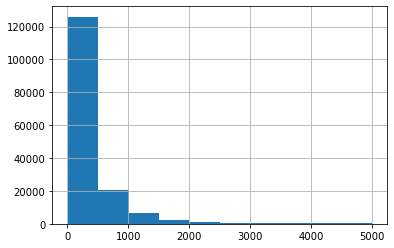

In [5]:
lens = train['comment_text'].str.len()
lens.hist()

In [6]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['clean'] = 1 - train[label_cols].max(axis=1)

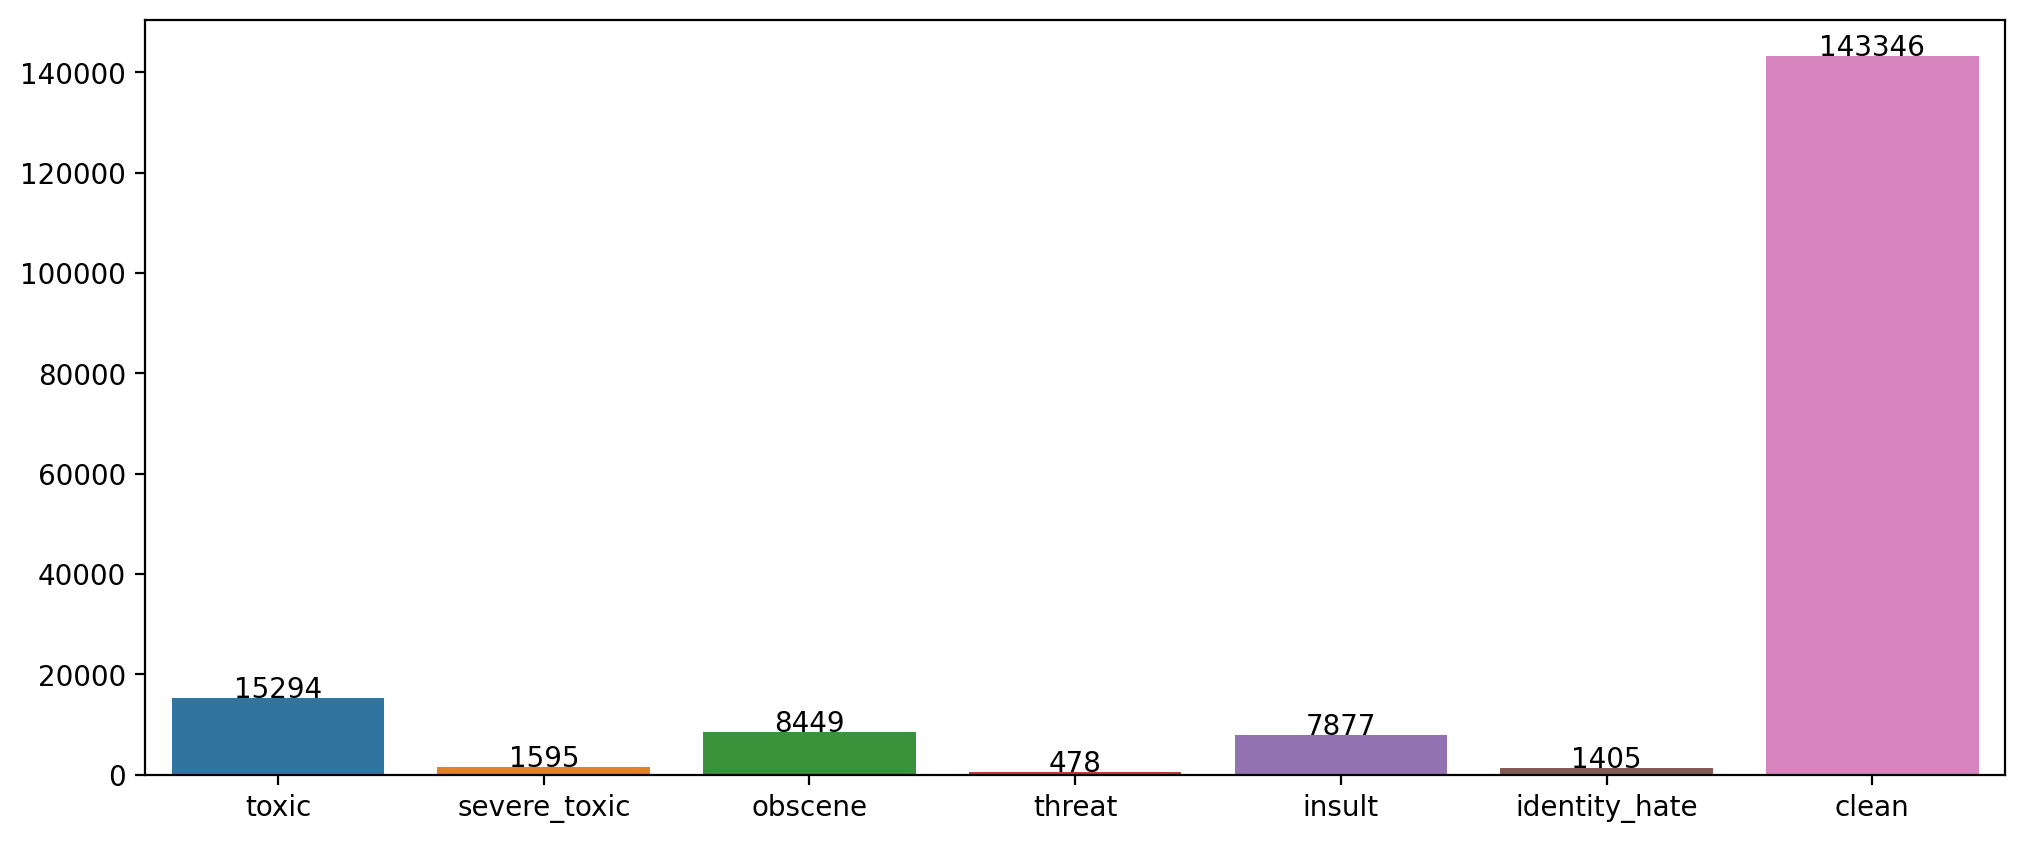

In [7]:
x = train.iloc[:, 2:].sum()
plt.figure(figsize=(12, 5), dpi=200)
ax = sns.barplot(x.index, x.values)
patches = ax.patches
diff = x.values.min() * 0.1
for patch, label in zip(patches, x.values):
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height() + diff, label, ha='center')

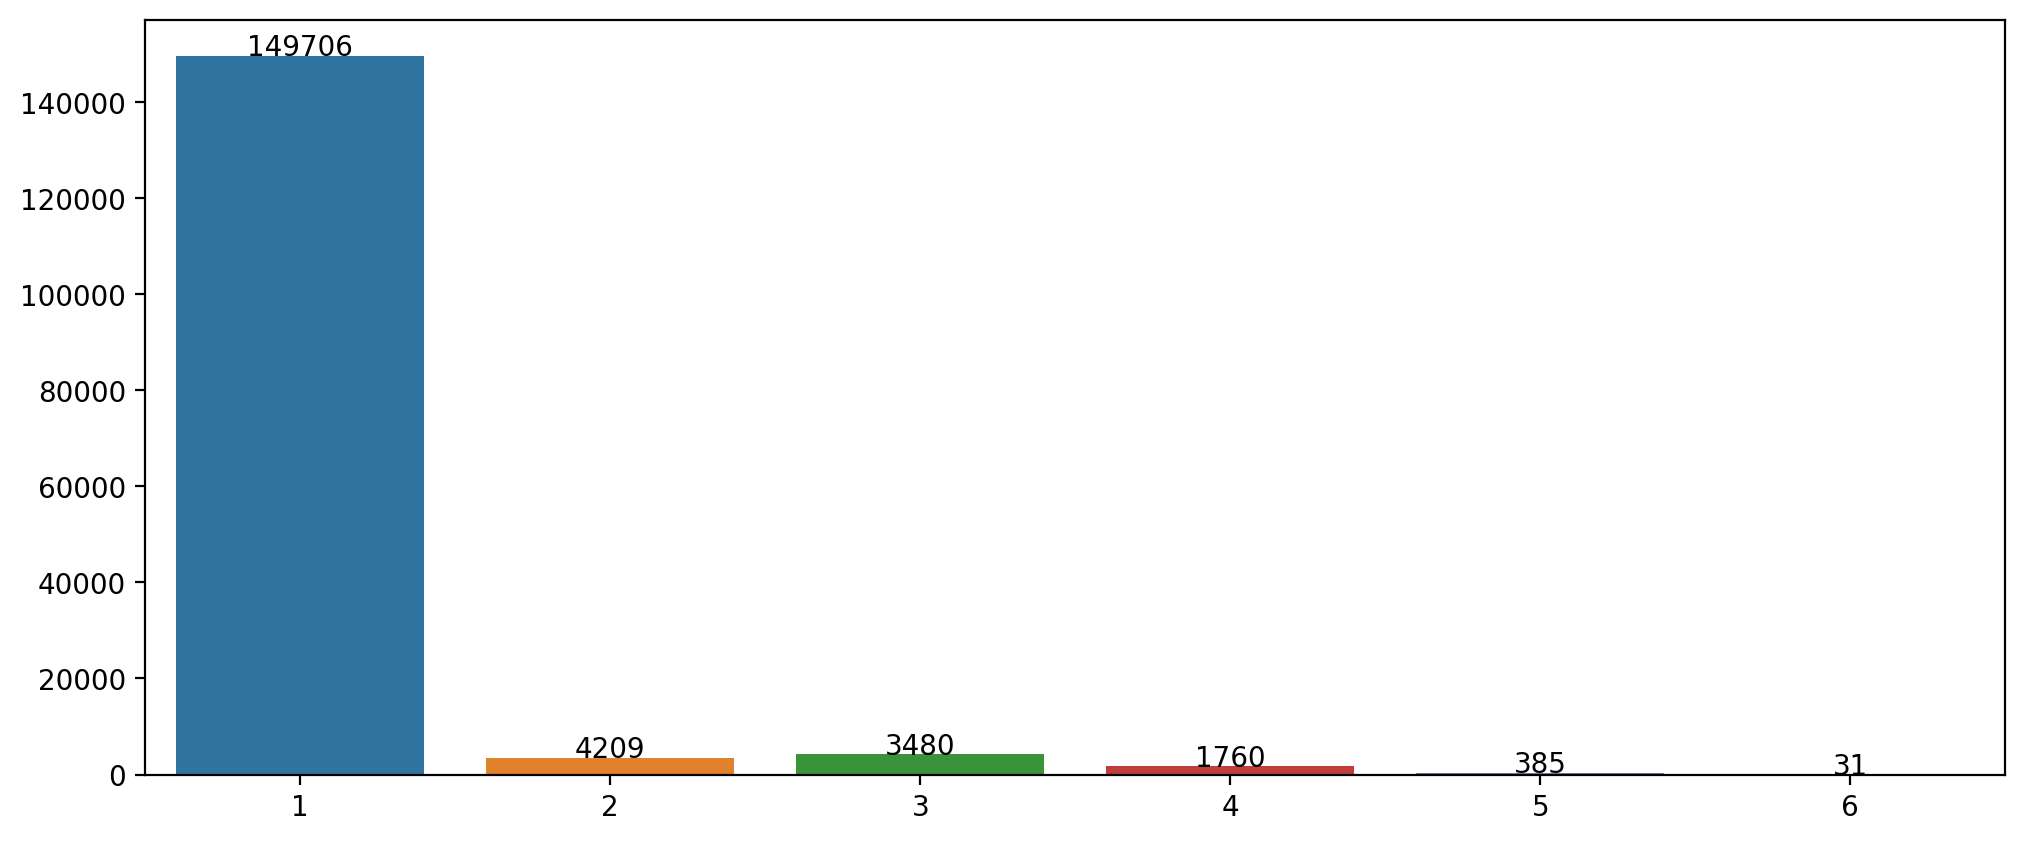

In [8]:
x = train.iloc[:, 2:].sum(1).value_counts()
plt.figure(figsize=(12, 5), dpi=200)
ax = sns.barplot(x.index, x.values)
patches = ax.patches
diff = x.values.min() * 0.1
for patch, label in zip(patches, x.values):
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height() + diff, label, ha='center')

<AxesSubplot:>

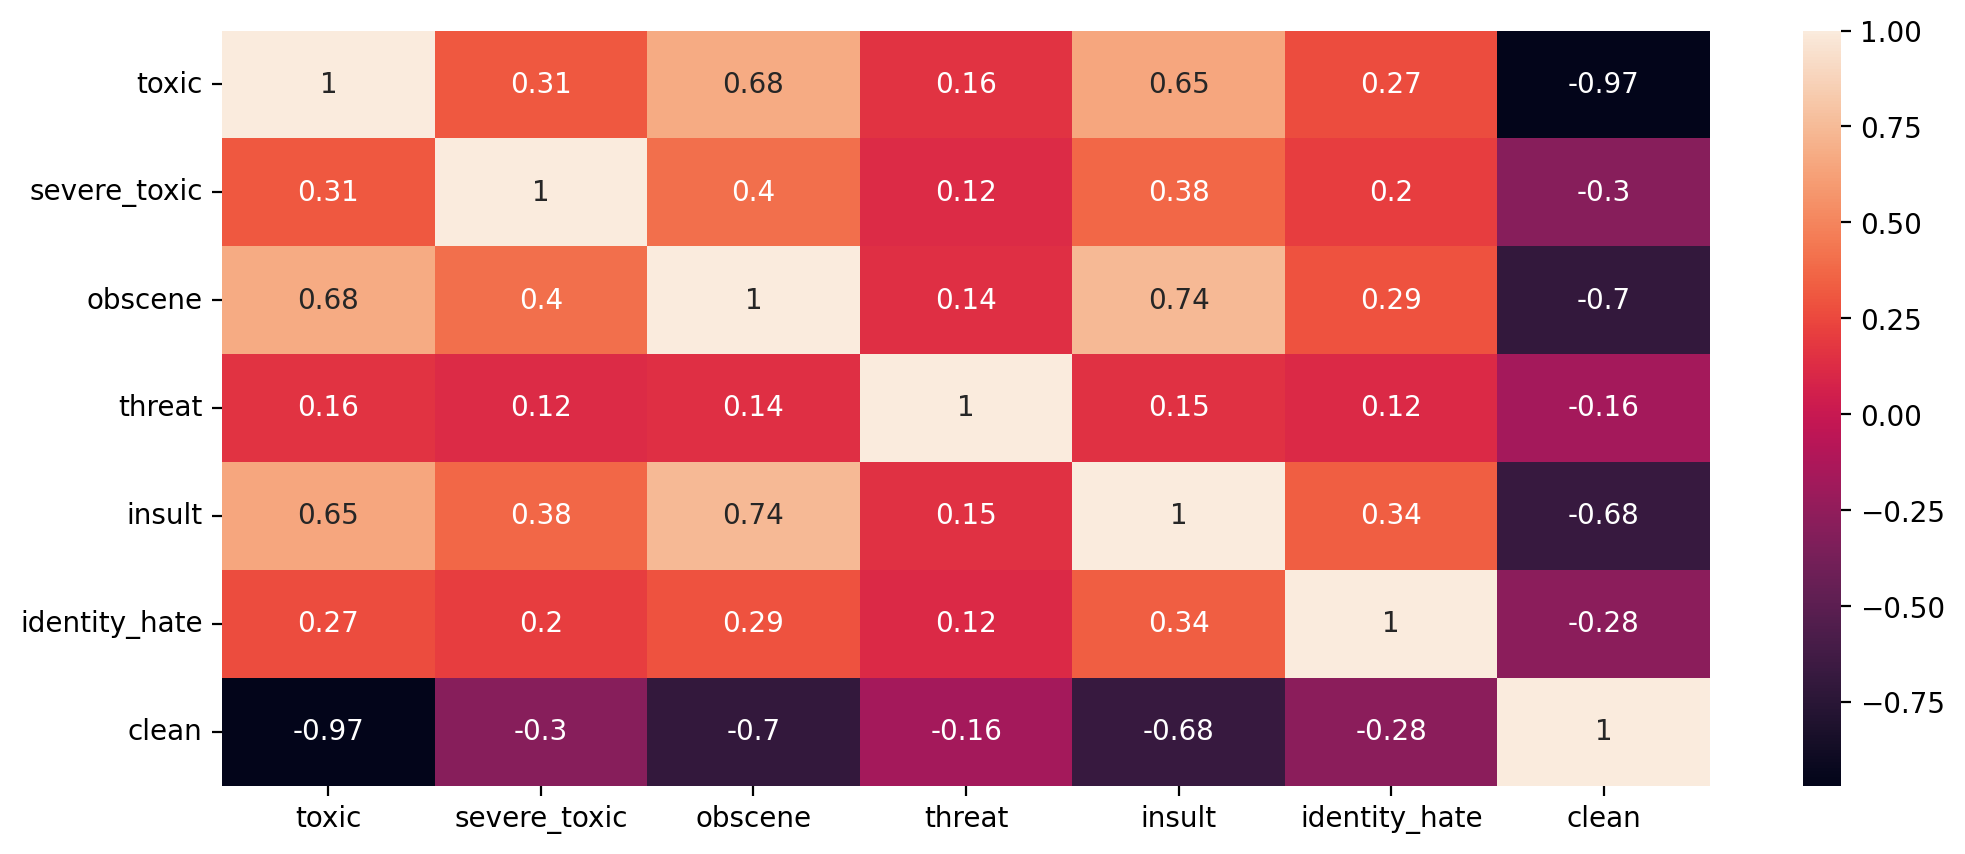

In [9]:
corr = train.iloc[:, 2:].corr()
plt.figure(figsize=(12, 5), dpi=200)
sns.heatmap(corr, annot=True)

In [10]:
toxic_df = train.iloc[:, 2:]
confusion_matrix = []
for main_col in toxic_df.columns:
    corr_df = []
    for other_col in toxic_df:
        cross_tab = pd.crosstab(toxic_df[main_col], toxic_df[other_col])
        corr_df.append(cross_tab)
    confusion_matrix.append(pd.concat(corr_df, axis=1, keys=toxic_df, names=['', 'is toxic']))
confusion_matrix = pd.concat(confusion_matrix, keys=toxic_df.columns, names=['', 'is toxic'])
confusion_matrix

toxic        severe_toxic       obscene        \
is toxic                     0      1            0     1       0     1   
              is toxic                                                   
toxic         0         144277      0       144277     0  143754   523   
              1              0  15294        13699  1595    7368  7926   
severe_toxic  0         144277  13699       157976     0  151044  6932   
              1              0   1595            0  1595      78  1517   
obscene       0         143754   7368       151044    78  151122     0   
              1            523   7926         6932  1517       0  8449   
threat        0         144248  14845       157610  1483  150945  8148   
              1             29    449          366   112     177   301   
insult        0         143744   7950       151470   224  149400  2294   
              1            533   7344         6506  1371    1722  6155   
identity_hate 0         144174  13992       156884  1282  150749  7417   
              1            103   1302         1092   313     373  1032   
clean         0            931  15294        14630  1595    7776  8449   
              1         143346      0       143346     0  143346     0   

                        threat       insult       identity_hate        clean  \
is toxic                     0    1       0     1             0     1      0   
              is toxic                                                         
toxic         0         144248   29  143744   533        144174   103    931   
              1          14845  449    7950  7344         13992  1302  15294   
severe_toxic  0         157610  366  151470  6506        156884  1092  14630   
              1           1483  112     224  1371          1282   313   1595   
obscene       0         150945  177  149400  1722        150749   373   7776   
              1           8148  301    2294  6155          7417  1032   8449   
threat        0         159093    0  151523  7570        157786  1307  15747   
              1              0  478     171   307           380    98    478   
insult        0         151523  171  151694     0        151449   245   8348   
              1           7570  307       0  7877          6717  1160   7877   
identity_hate 0         157786  380  151449  6717        158166     0  14820   
              1           1307   98     245  1160             0  1405   1405   
clean         0          15747  478    8348  7877         14820  1405  16225   
              1         143346    0  143346     0        143346     0      0   

                                
is toxic                     1  
              is toxic          
toxic         0         143346  
              1              0  
severe_toxic  0         143346  
              1              0  
obscene       0         143346  
              1              0  
threat        0         143346  
              1              0  
insult        0         143346  
              1              0  
identity_hate 0         143346  
              1              0  
clean         0              0  
              1         143346

In [11]:
def cramer_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_bias = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    k_bias = k - (k - 1)**2 / (n - 1)
    r_bias = r - (r - 1)**2 / (n - 1)
    return np.sqrt(phi2_bias / min(r_bias - 1, k_bias - 1))

<AxesSubplot:>

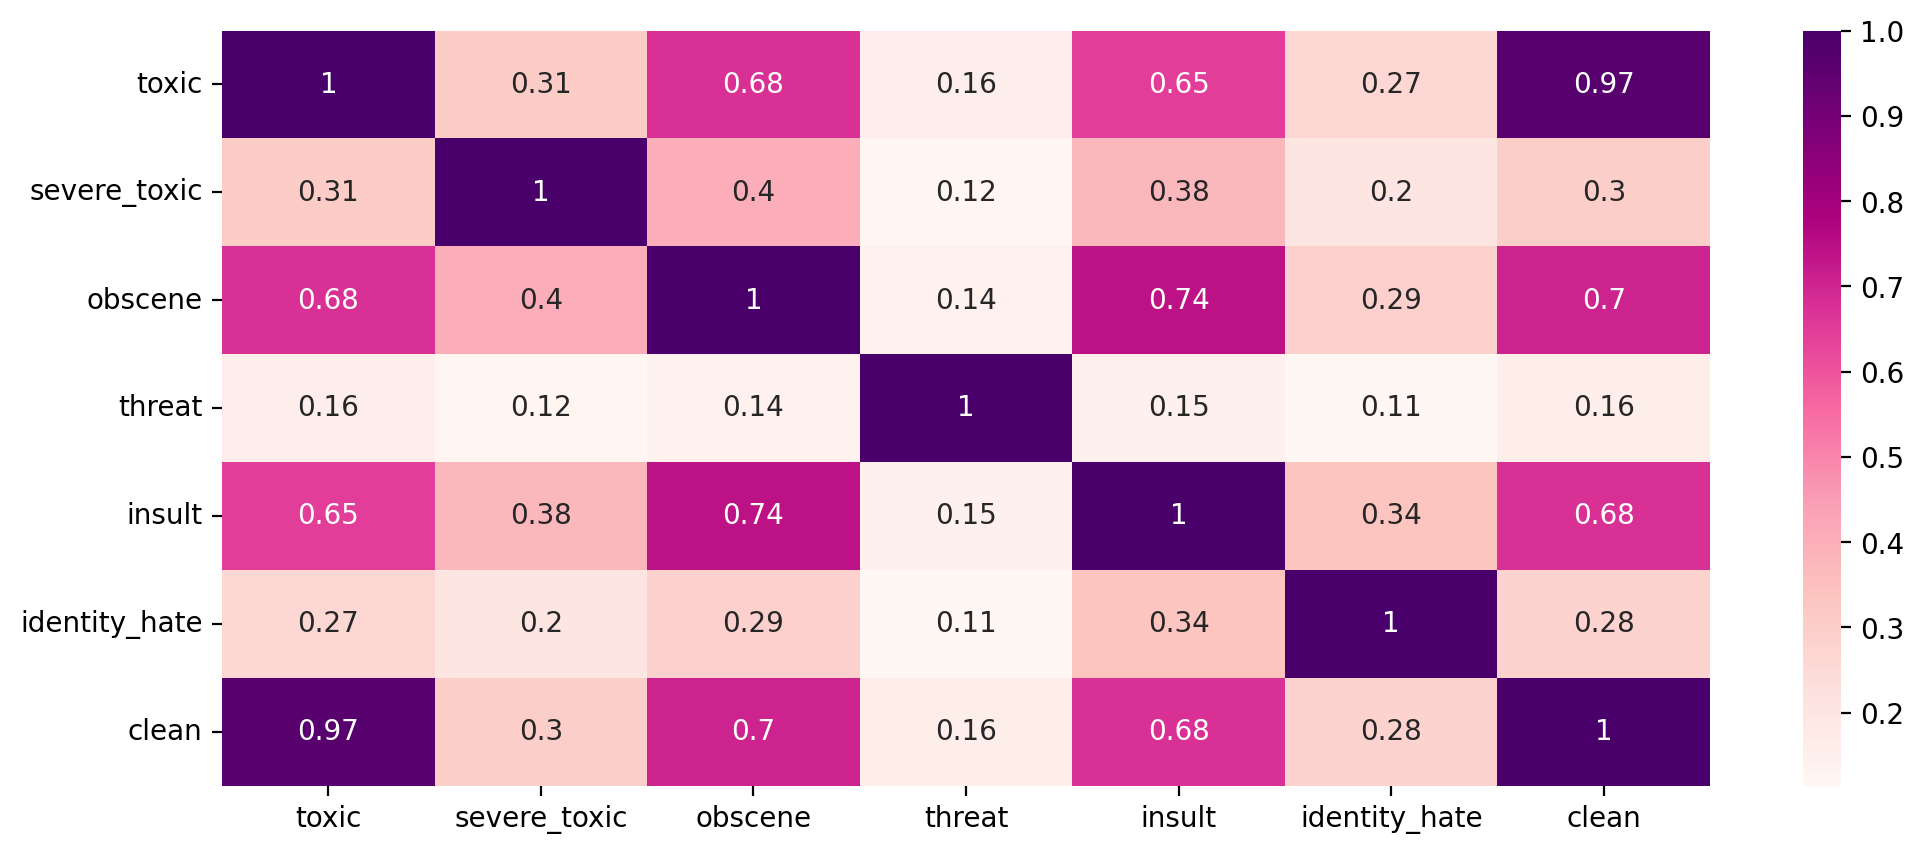

In [12]:
cramer_df = pd.DataFrame(index=toxic_df.columns, columns=toxic_df.columns)
for row in toxic_df.columns:
    for col in toxic_df.columns:
        if row == col:
            cramer_df[row][col] = 1.0
            continue
        matrix = confusion_matrix.loc[row][col]
        cramer_df[row][col] = cramer_v(matrix)

plt.figure(figsize=(12, 5), dpi=200)
sns.heatmap(cramer_df.astype(np.float), annot=True, cmap='RdPu')

(-0.5, 399.5, 199.5, -0.5)

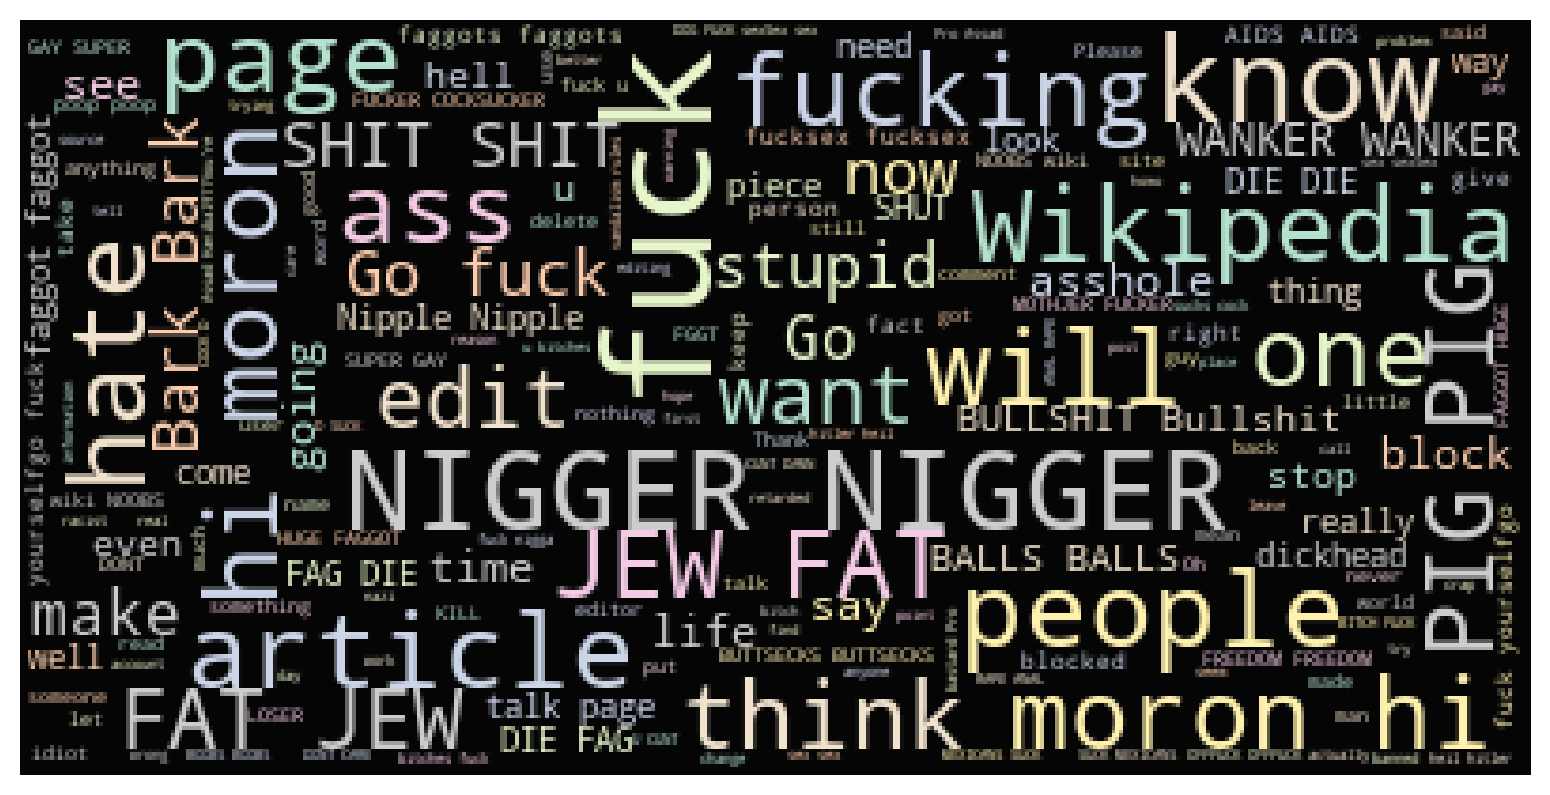

In [13]:
from wordcloud import WordCloud, STOPWORDS
toxic = train[train['toxic'] == 1]['comment_text']
plt.figure(figsize=(12, 5), dpi=200)
wc = WordCloud(background_color='black', max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(toxic.values))
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

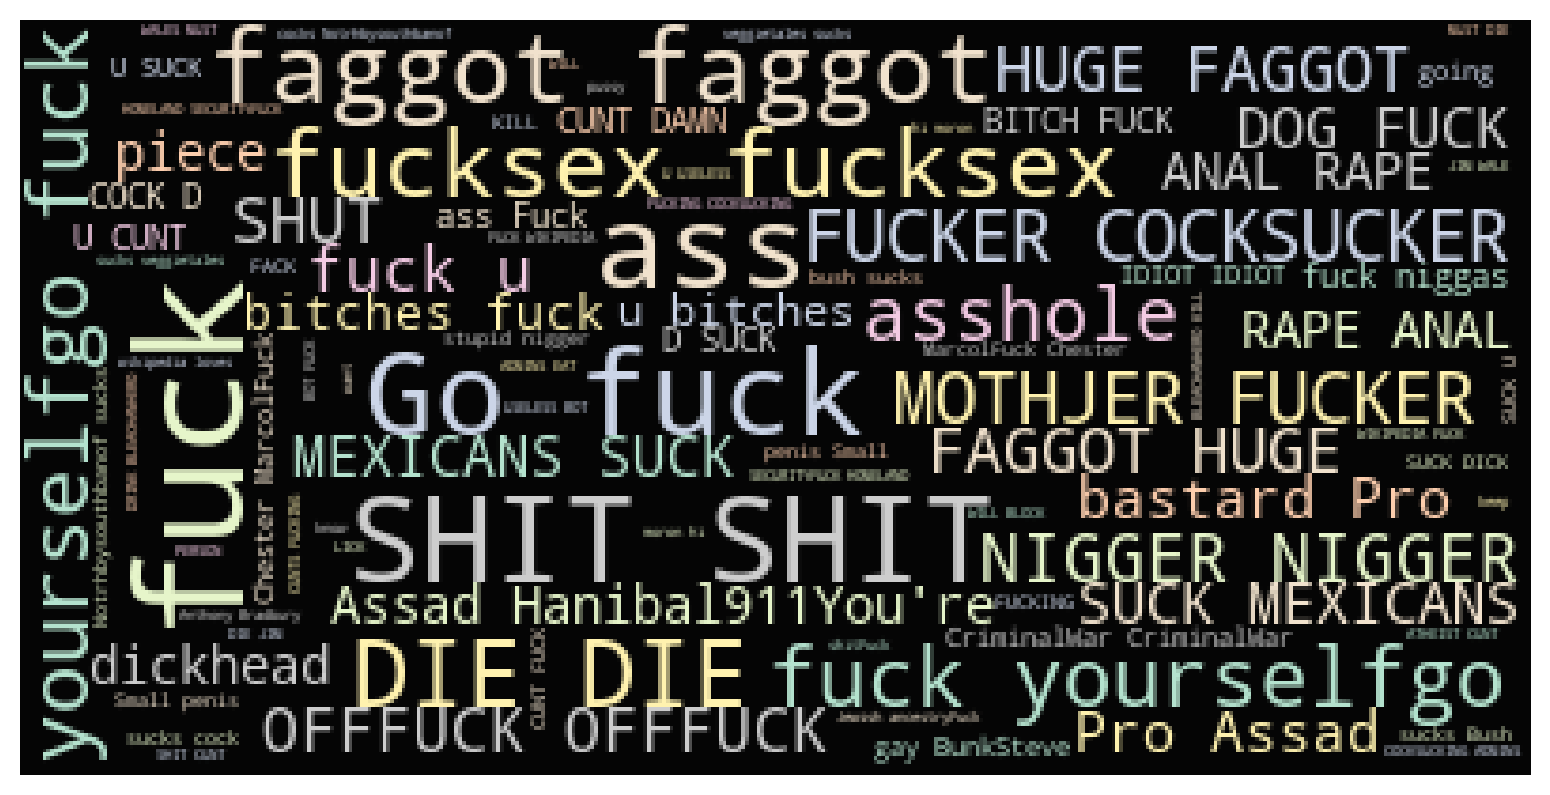

In [14]:
severe_toxic = train[train['severe_toxic'] == 1]['comment_text']
plt.figure(figsize=(12, 5), dpi=200)
wc = WordCloud(background_color='black', max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(severe_toxic.values))
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

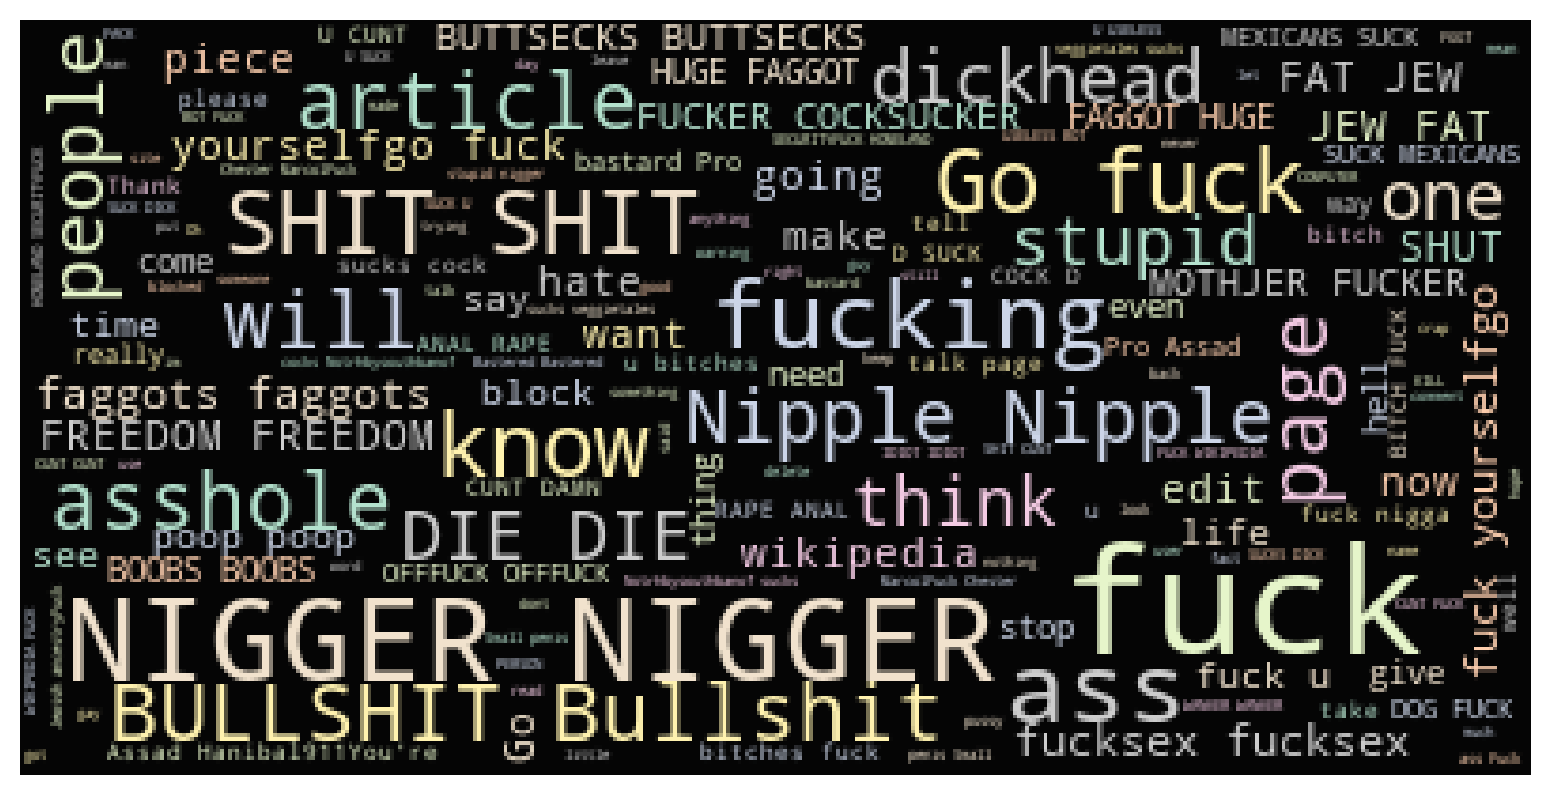

In [15]:
obscene = train[train['obscene'] == 1]['comment_text']
plt.figure(figsize=(12, 5), dpi=200)
wc = WordCloud(background_color='black', max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(obscene.values))
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

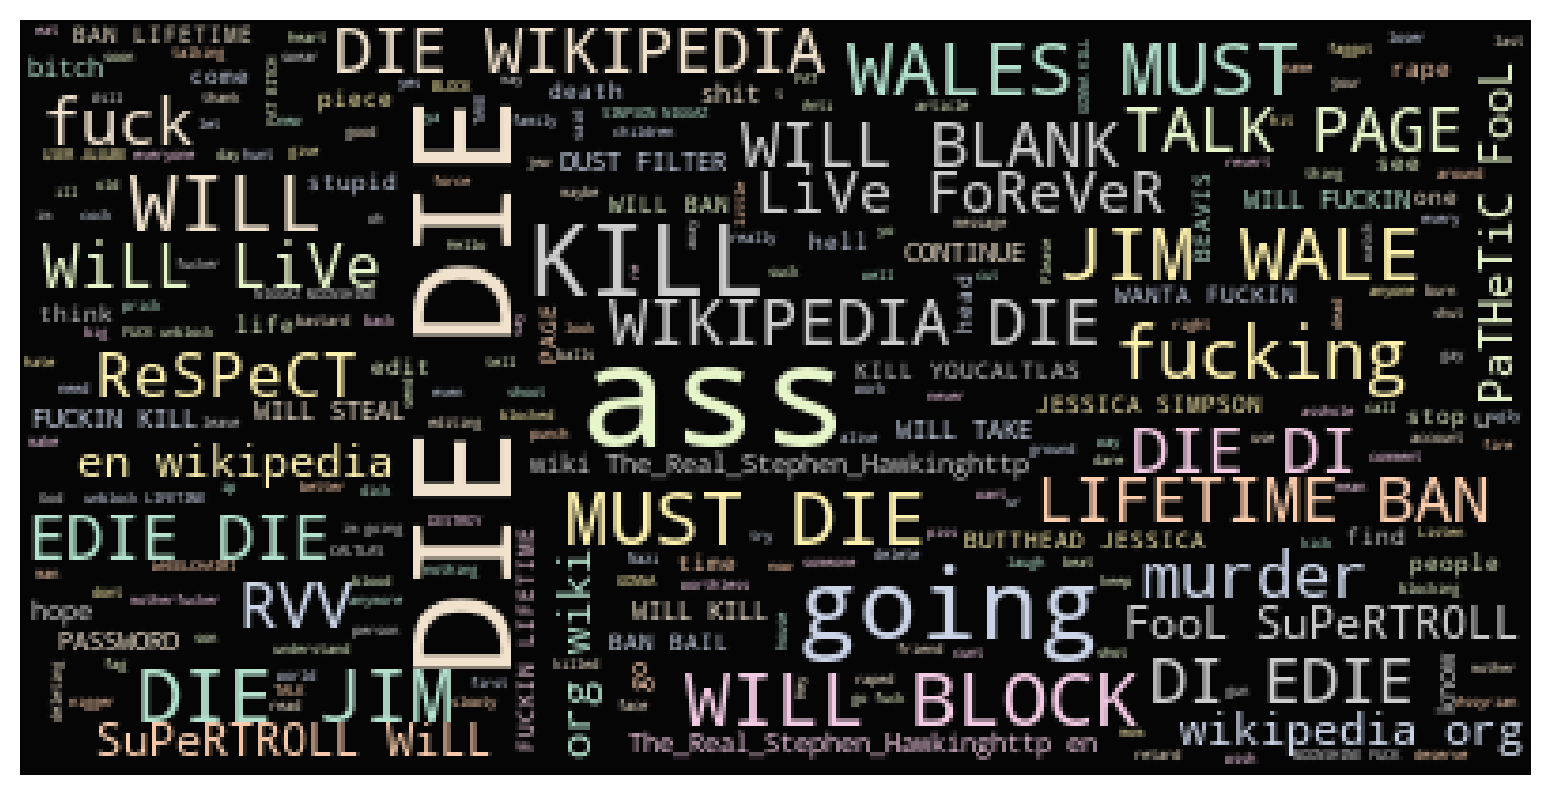

In [16]:
threat = train[train['threat'] == 1]['comment_text']
plt.figure(figsize=(12, 5), dpi=200)
wc = WordCloud(background_color='black', max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(threat.values))
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

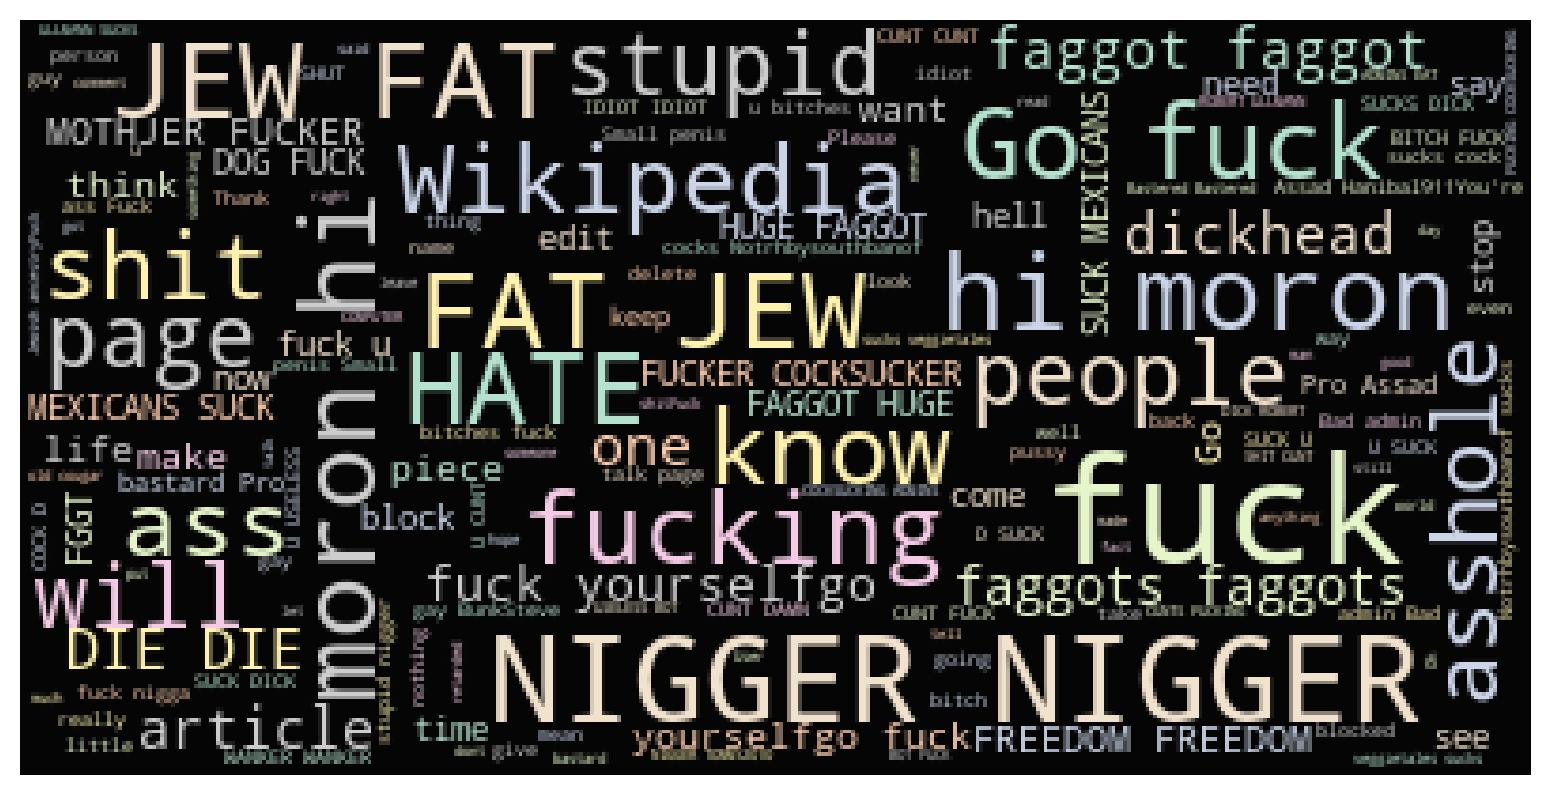

In [17]:
insult = train[train['insult'] == 1]['comment_text']
plt.figure(figsize=(12, 5), dpi=200)
wc = WordCloud(background_color='black', max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(insult.values))
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

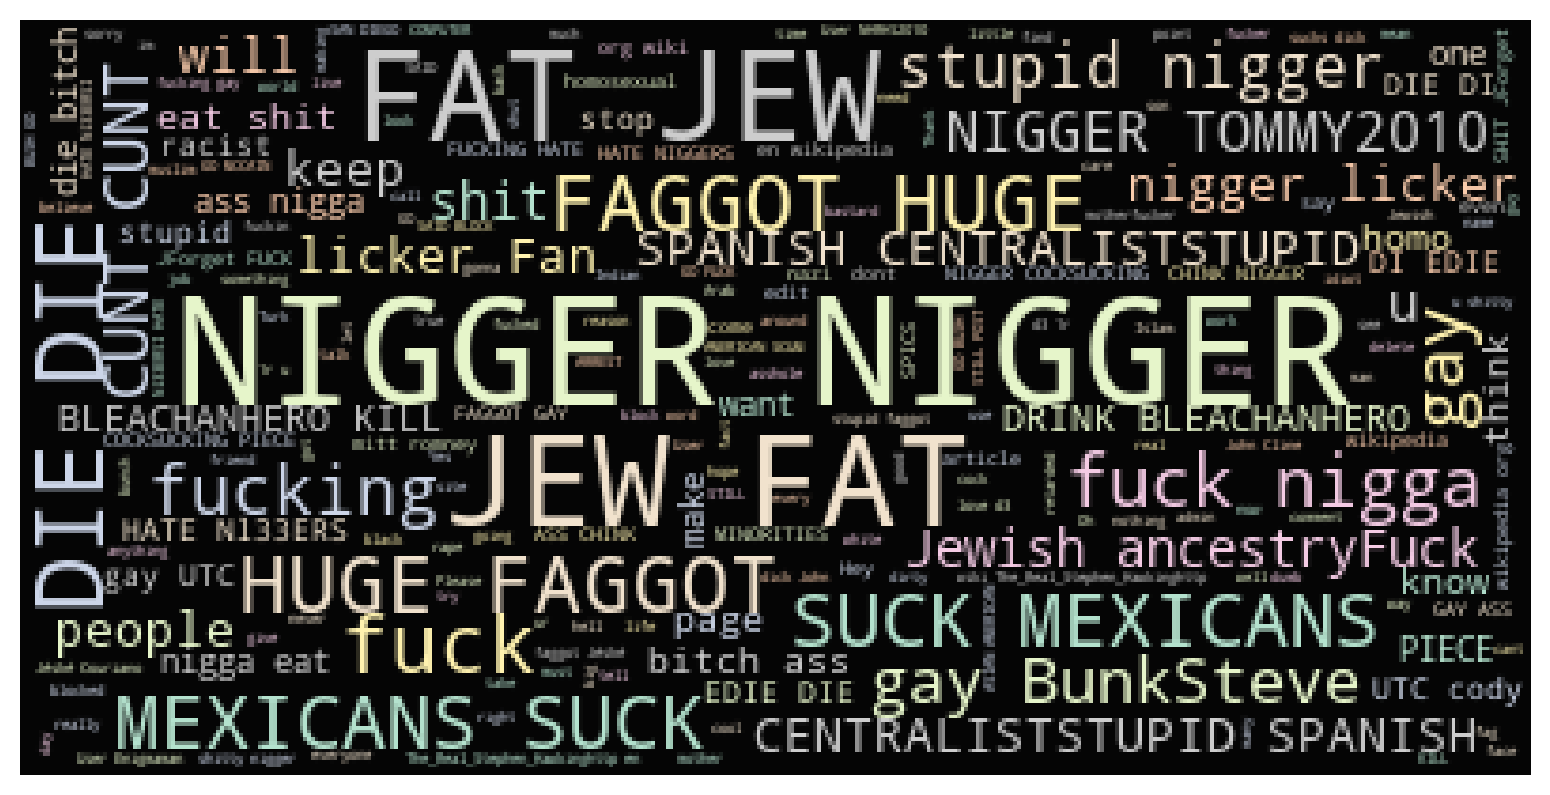

In [18]:
identity_hate = train[train['identity_hate'] == 1]['comment_text']
plt.figure(figsize=(12, 5), dpi=200)
wc = WordCloud(background_color='black', max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(identity_hate.values))
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

In [20]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":"we will",
"didn't": "did not",
"tryin'":"trying"
}

In [47]:
tokenizer = TweetTokenizer()
lemm = nltk.stem.WordNetLemmatizer()
eng_stopwords = set(stopwords.words('english'))
def clean(comment):
    comment = comment.lower()
    comment = re.sub('\n', ' ', comment)
    comment = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', comment)
    comment = re.sub('\[\[.*\]', '', comment)
    
    words = tokenizer.tokenize(comment)
    words = [APPO[word] if word in APPO else word for word in words]
    words = [word for word in words if word not in eng_stopwords]
    words = [lemm.lemmatize(word, 'v') for word in words]
    
    cleaned = ' '.join(words)
    return cleaned

In [98]:
def get_tf(df, ngram_range=(1, 1)):
    tf = TfidfVectorizer(min_df=200, max_features=10000, strip_accents='unicode', 
                         sublinear_tf=1, stop_words='english', ngram_range=ngram_range)
    tf.fit(df['comment_text'])
    return tf

In [157]:
def top_mean_feats(matrix, features, index, top_n=20, min_tfidf=0.1):
    df = matrix[index].toarray()
    df[df < min_tfidf] = 0
    df = df.mean(axis=0)
    
    top_indexs = np.argsort(df)[::-1][:top_n]
    top_feats = [(features[i], df[i]) for i in top_indexs]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [158]:
def top_feats_by_class(matrix, features, top_n=20, min_tfidf=0.1):
    dfs = []
    cols = toxic_df.columns[:-1]
    for col in cols:
        indexs = train[train[col] == 1].index
        feats_df = top_mean_feats(matrix, features, indexs, top_n=top_n, min_tfidf=min_tfidf)
        feats_df.label = col
        dfs.append(feats_df)
    return dfs

In [99]:
data = pd.concat([train, test], axis=0, ignore_index=True)
uni_tf = get_tf(data)
train_unigrams = uni_tf.transform(train['comment_text'])
test_unigrams = uni_tf.transform(test['comment_text'])

In [159]:
uni_features = uni_tf.get_feature_names_out()
top_uni_tfidf = top_feats_by_class(train_unigrams, uni_features, top_n=10)

In [187]:
def plot_data(dfs, top_n=10, kind='unigrams'):
    plt.figure(figsize=(16, 22), dpi=200)
    plt.suptitle(f'TF_IDF top words per class {kind}', size=20)
    gridspec.GridSpec(3, 2)
    
    titles = toxic_df.columns[:-1]
    
    for i in range(6):
        plt.subplot2grid((3, 2), (int(i / 2), int(i % 2)))
        sns.barplot(dfs[i][:top_n]['feature'], dfs[i][:top_n]['tfidf'])
        plt.title(f'Class: {titles[i]}', size=15)
        plt.xlabel('Word', size=12)
        plt.ylabel('TF_IDF', size=12)
    plt.show()

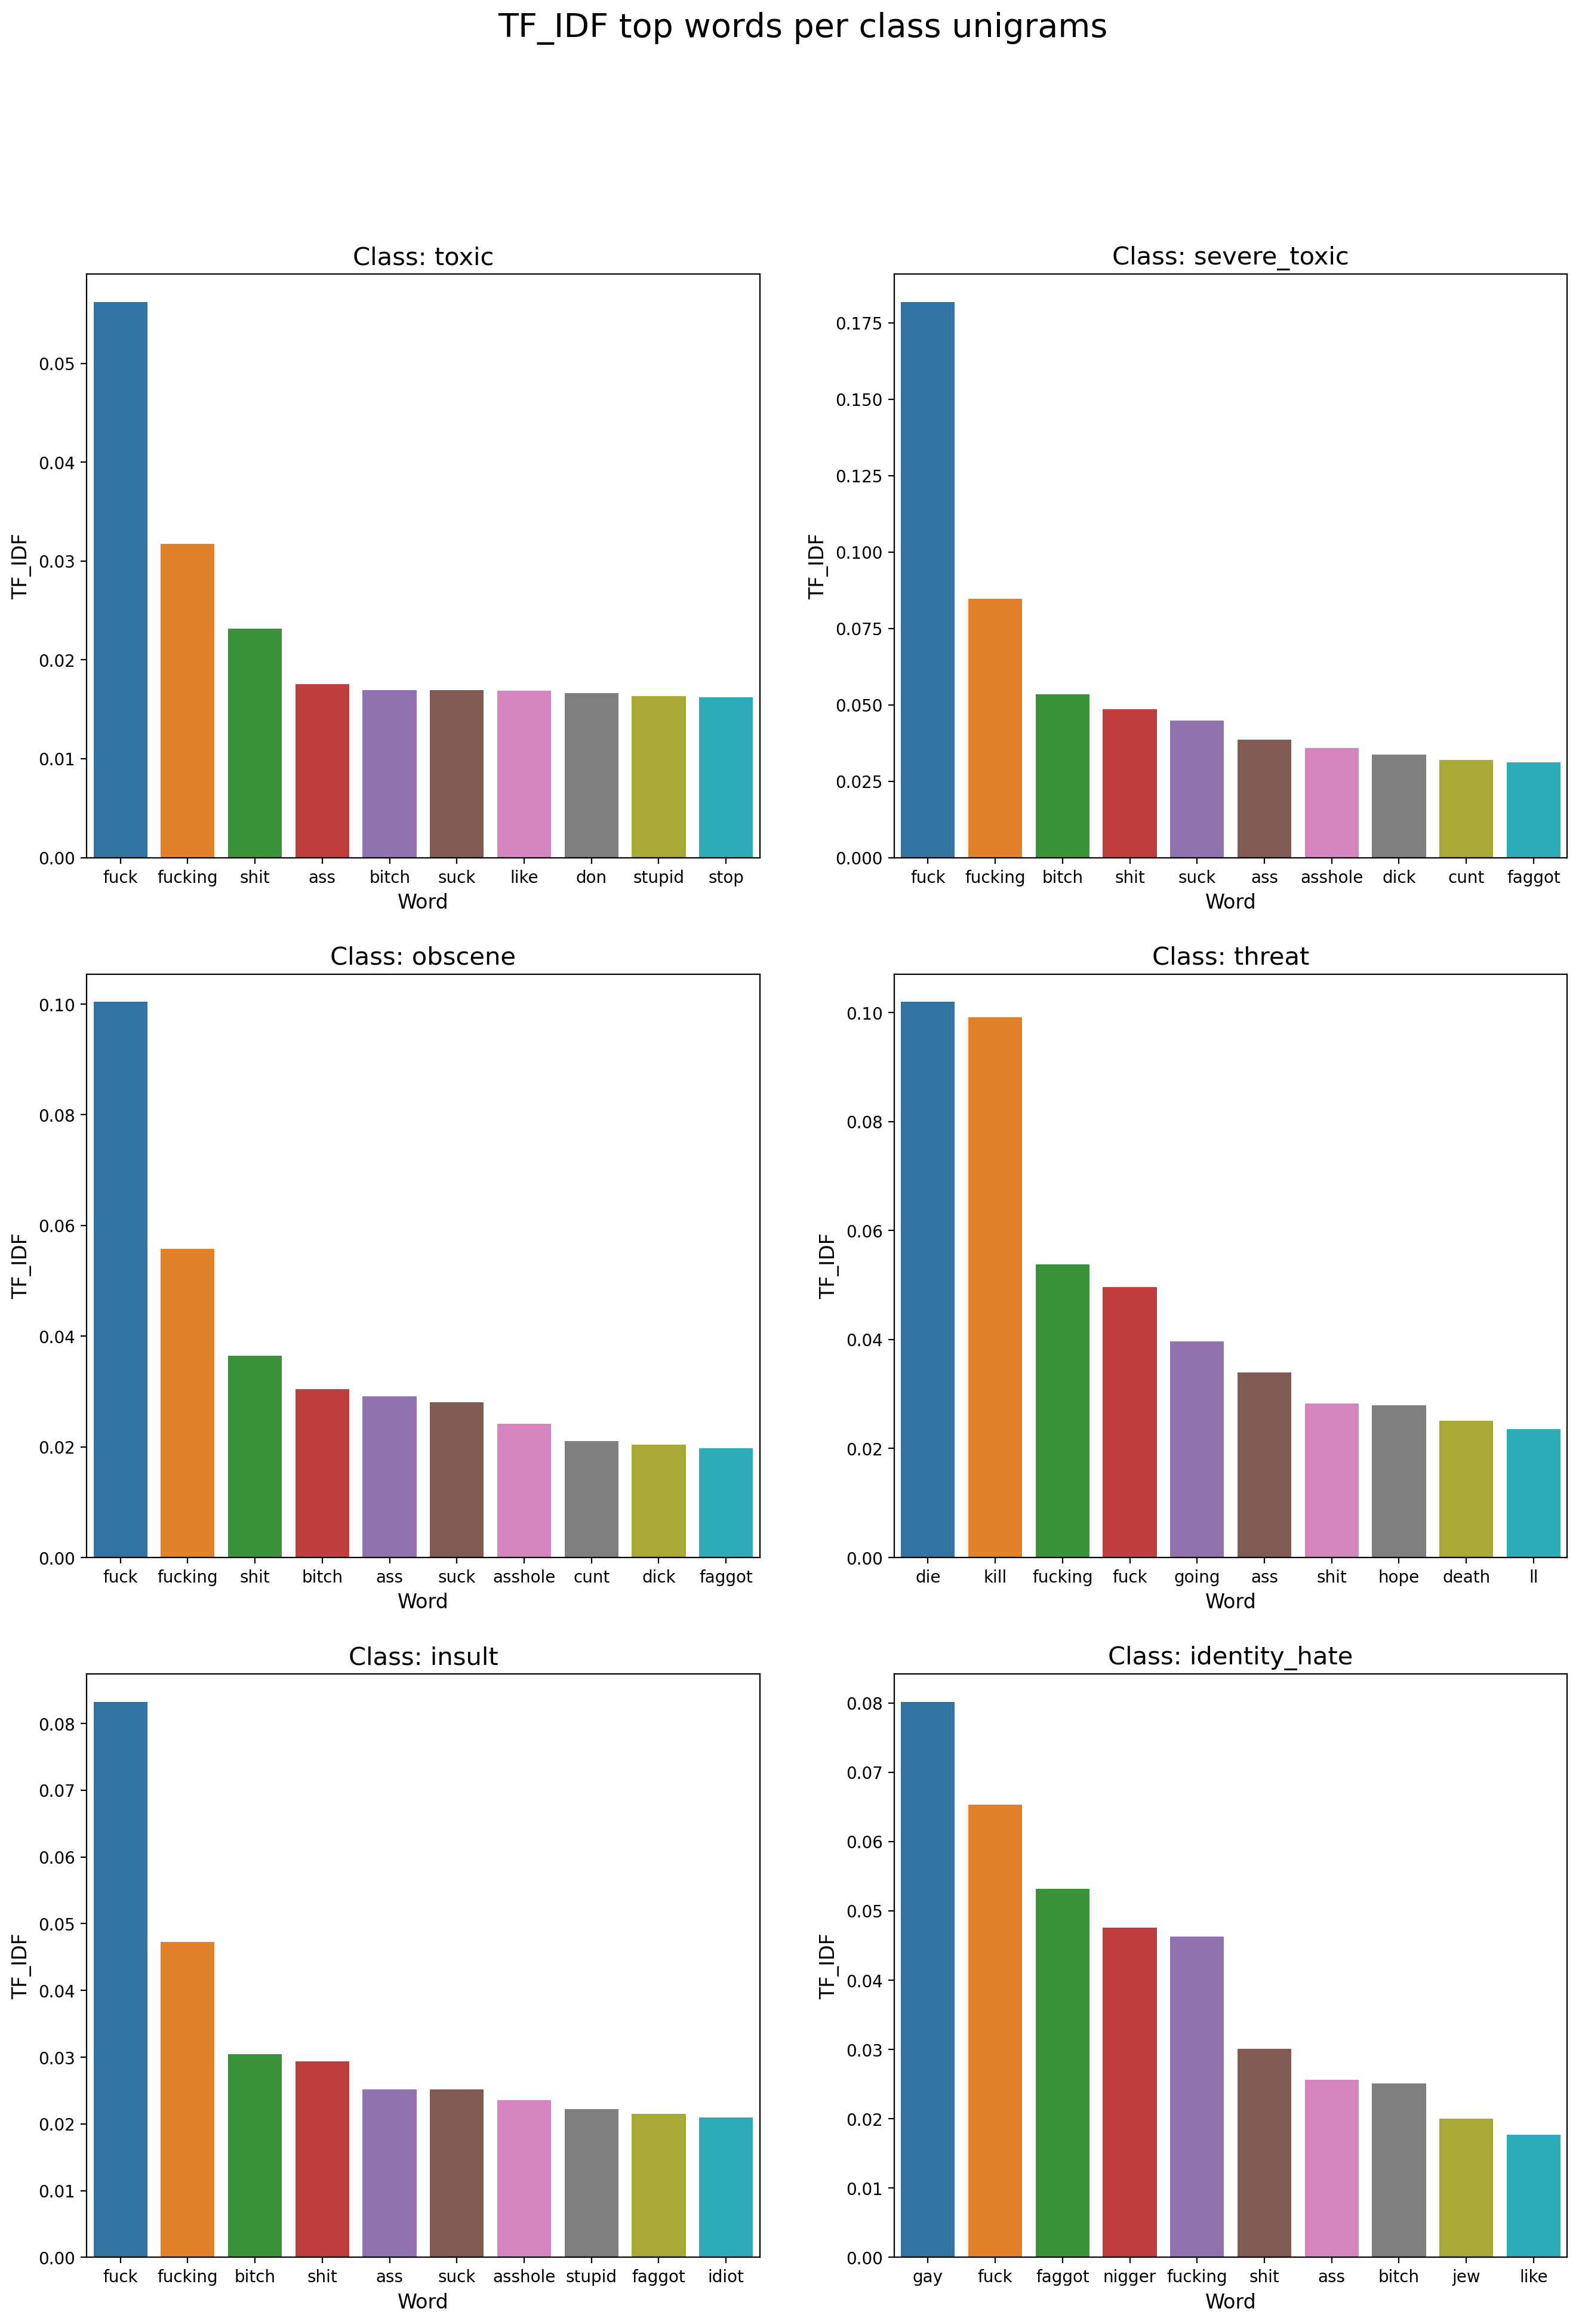

In [188]:
plot_data(top_uni_tfidf)

In [183]:
bi_tf = get_tf(data, ngram_range=(2, 2))
train_bigrams = bi_tf.transform(train['comment_text'])
test_bigrams = bi_tf.transform(test['comment_text'])

In [184]:
bi_features = bi_tf.get_feature_names_out()
top_bi_tfidf = top_feats_by_class(train_bigrams, bi_features, top_n=10)

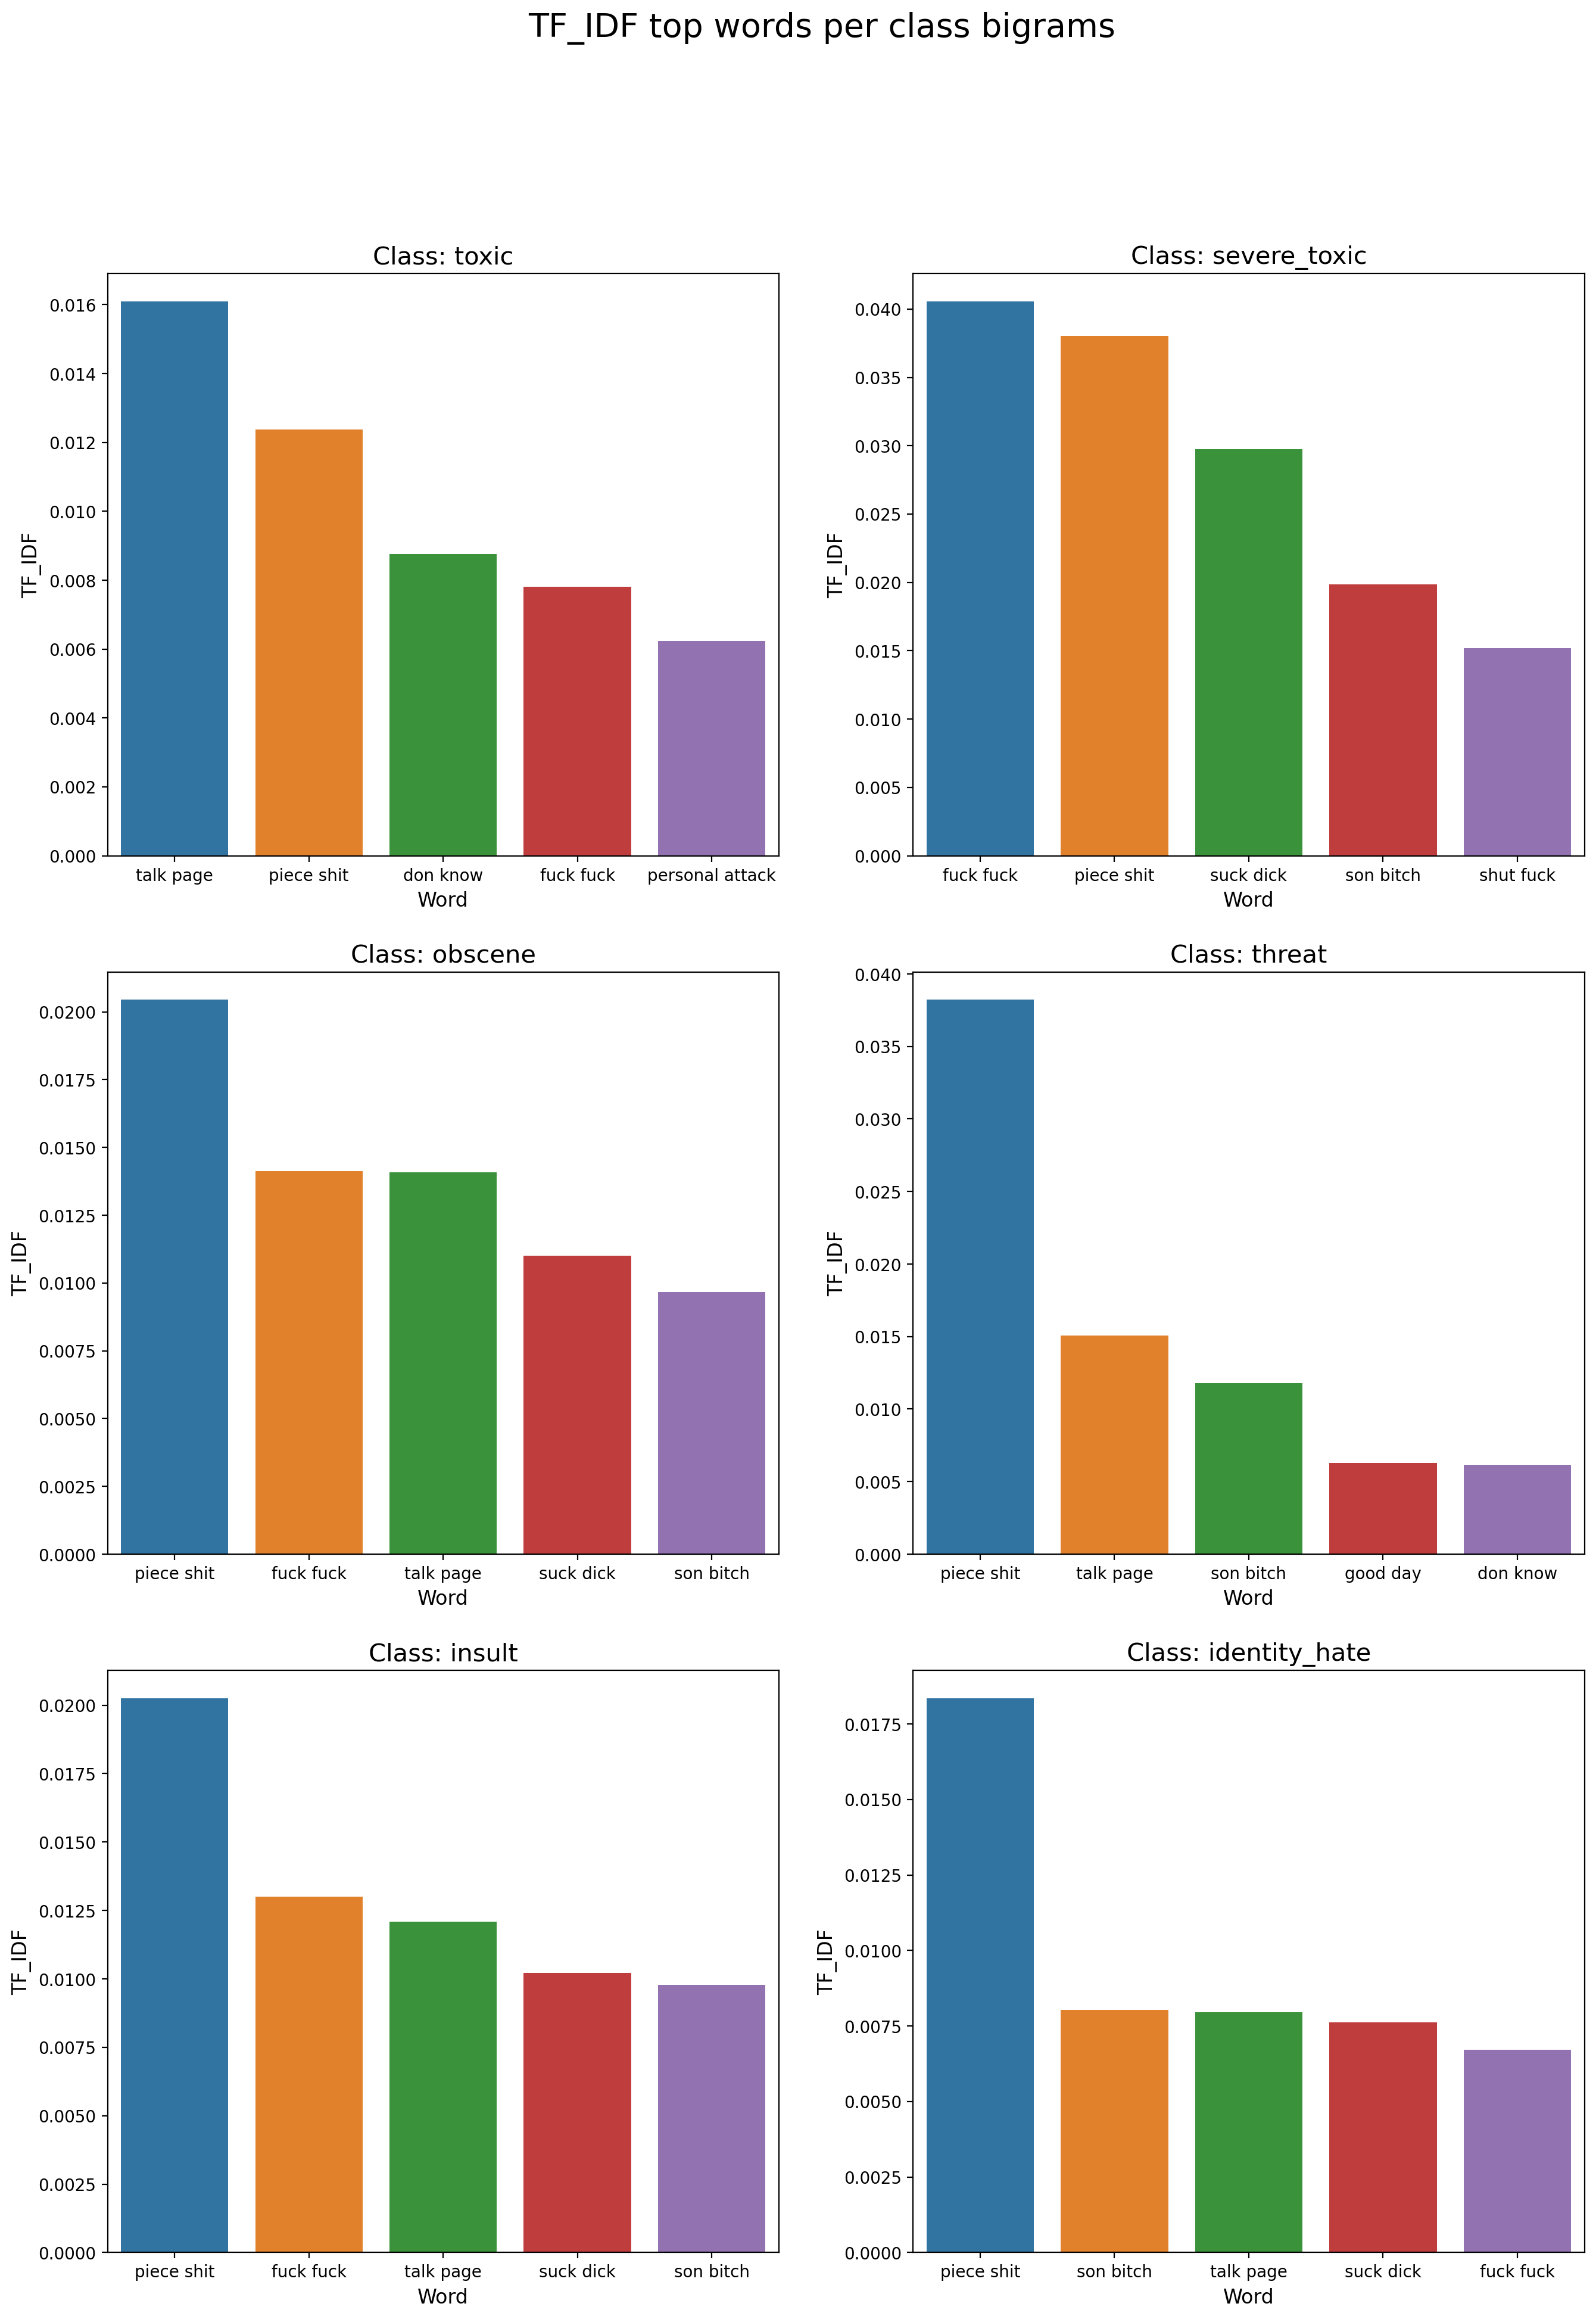

In [190]:
plot_data(top_bi_tfidf, top_n=5, kind='bigrams')

In [19]:
import nltk
lemm = nltk.stem.WordNetLemmatizer()
class LemmCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [20]:
count_vec = LemmCountVectorizer(max_df=0.9, min_df=3, strip_accents='unicode', 
                                decode_error='ignore', stop_words='english')
x = count_vec.fit_transform(train['comment_text'])

<AxesSubplot:>

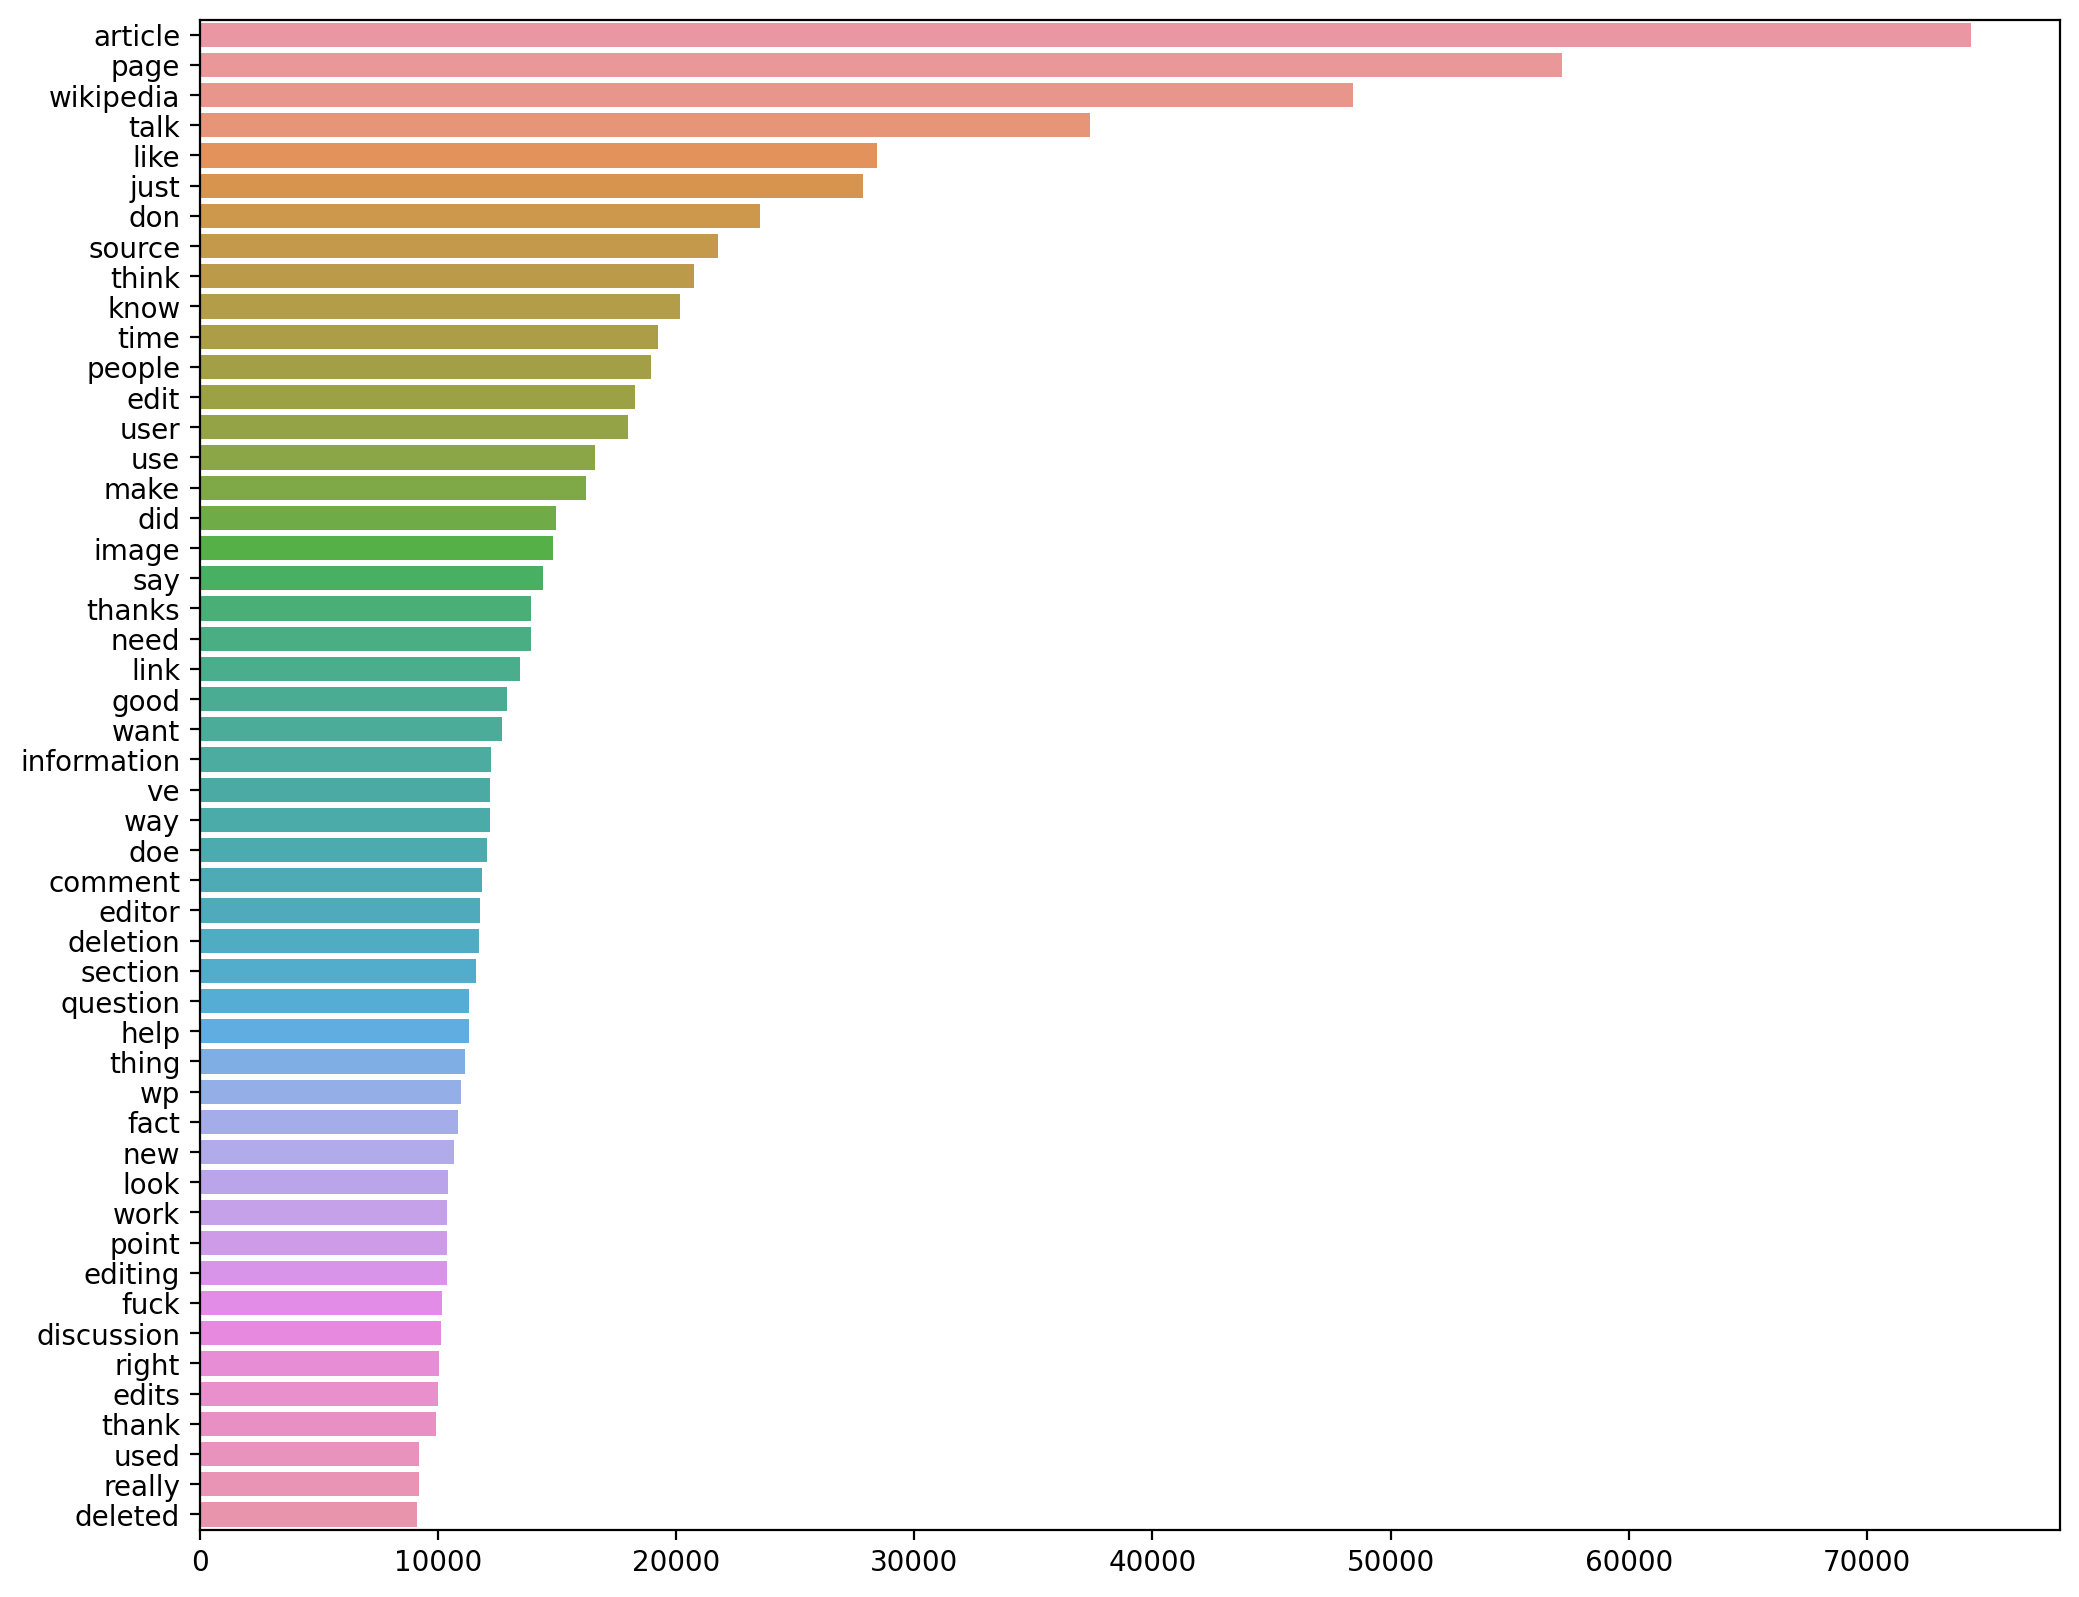

In [21]:
df = pd.DataFrame(x.sum(axis=0).reshape(-1, 1), index=count_vec.get_feature_names_out(), columns=['frequency'])
df =df.sort_values('frequency', ascending=0)

plt.figure(figsize=(12, 10), dpi=200)
top_50 = df[:50]
sns.barplot(x=top_50.values.reshape(-1), y=top_50.index, orient='h')

In [42]:
from nltk.corpus import stopwords
import re, string
full_data = pd.concat([train.iloc[:, :2], test.iloc[:, :2]])
token = re.compile(f'([{string.punctuation}])')
full_data['word_count'] = full_data['comment_text'].apply(lambda x: len(x.split()))
full_data['character_count'] = full_data['comment_text'].apply(lambda x: len(x))
full_data['punc_count'] = full_data['comment_text'].apply(lambda x: len(token.findall(str(x))))
full_data['sentence_count'] = full_data['comment_text'].apply(lambda x: len(re.findall('\n', x)) + 1)
# full_data['upper_word_count'] = full_data['comment_text'].apply(lambda x: len([w for w in x.split() if w.isupper()]))
# full_data['title_word_count'] = full_data['comment_text'].apply(lambda x: len([w for w in x.split() if w.istitle()]))
full_data['unique_word_count'] = full_data['comment_text'].apply(lambda x: len(set(x.split())))
# full_data['stopword_count'] = full_data['comment_text'].apply(lambda x: len([w for w in x.split() if w in stopwords.words('english')]))
full_data['spam_rate']  = 1 - full_data['unique_word_count'] / full_data['word_count']
full_data['punc_percent'] = full_data['punc_count'] / full_data['character_count']

In [43]:
f_train = full_data.iloc[:len(train)]
f_test = full_data.iloc[len(train):]
f_train = pd.concat([f_train, toxic_df], axis=1)

In [61]:
def plot_data(df, feature):
    fig = plt.figure(figsize=(12, 10), dpi=200)
    gs = fig.add_gridspec(2, 2)
    ax = [None for _ in range(4)]
    ax[0] = fig.add_subplot(gs[0, 0])
    toxic = df[df['clean'] == 0][feature]
    sns.histplot(toxic, bins=50, ax=ax[0])
    
    ax[1] = fig.add_subplot(gs[0, 1])
    non_toxic = df[df['clean'] == 1][feature]
    sns.histplot(non_toxic, bins=50, ax=ax[1])
    
    ax[2] = fig.add_subplot(gs[1, :])
    sns.histplot(x=df[feature], bins=50, hue=df['clean'], ax=ax[2])
    
    plt.show()

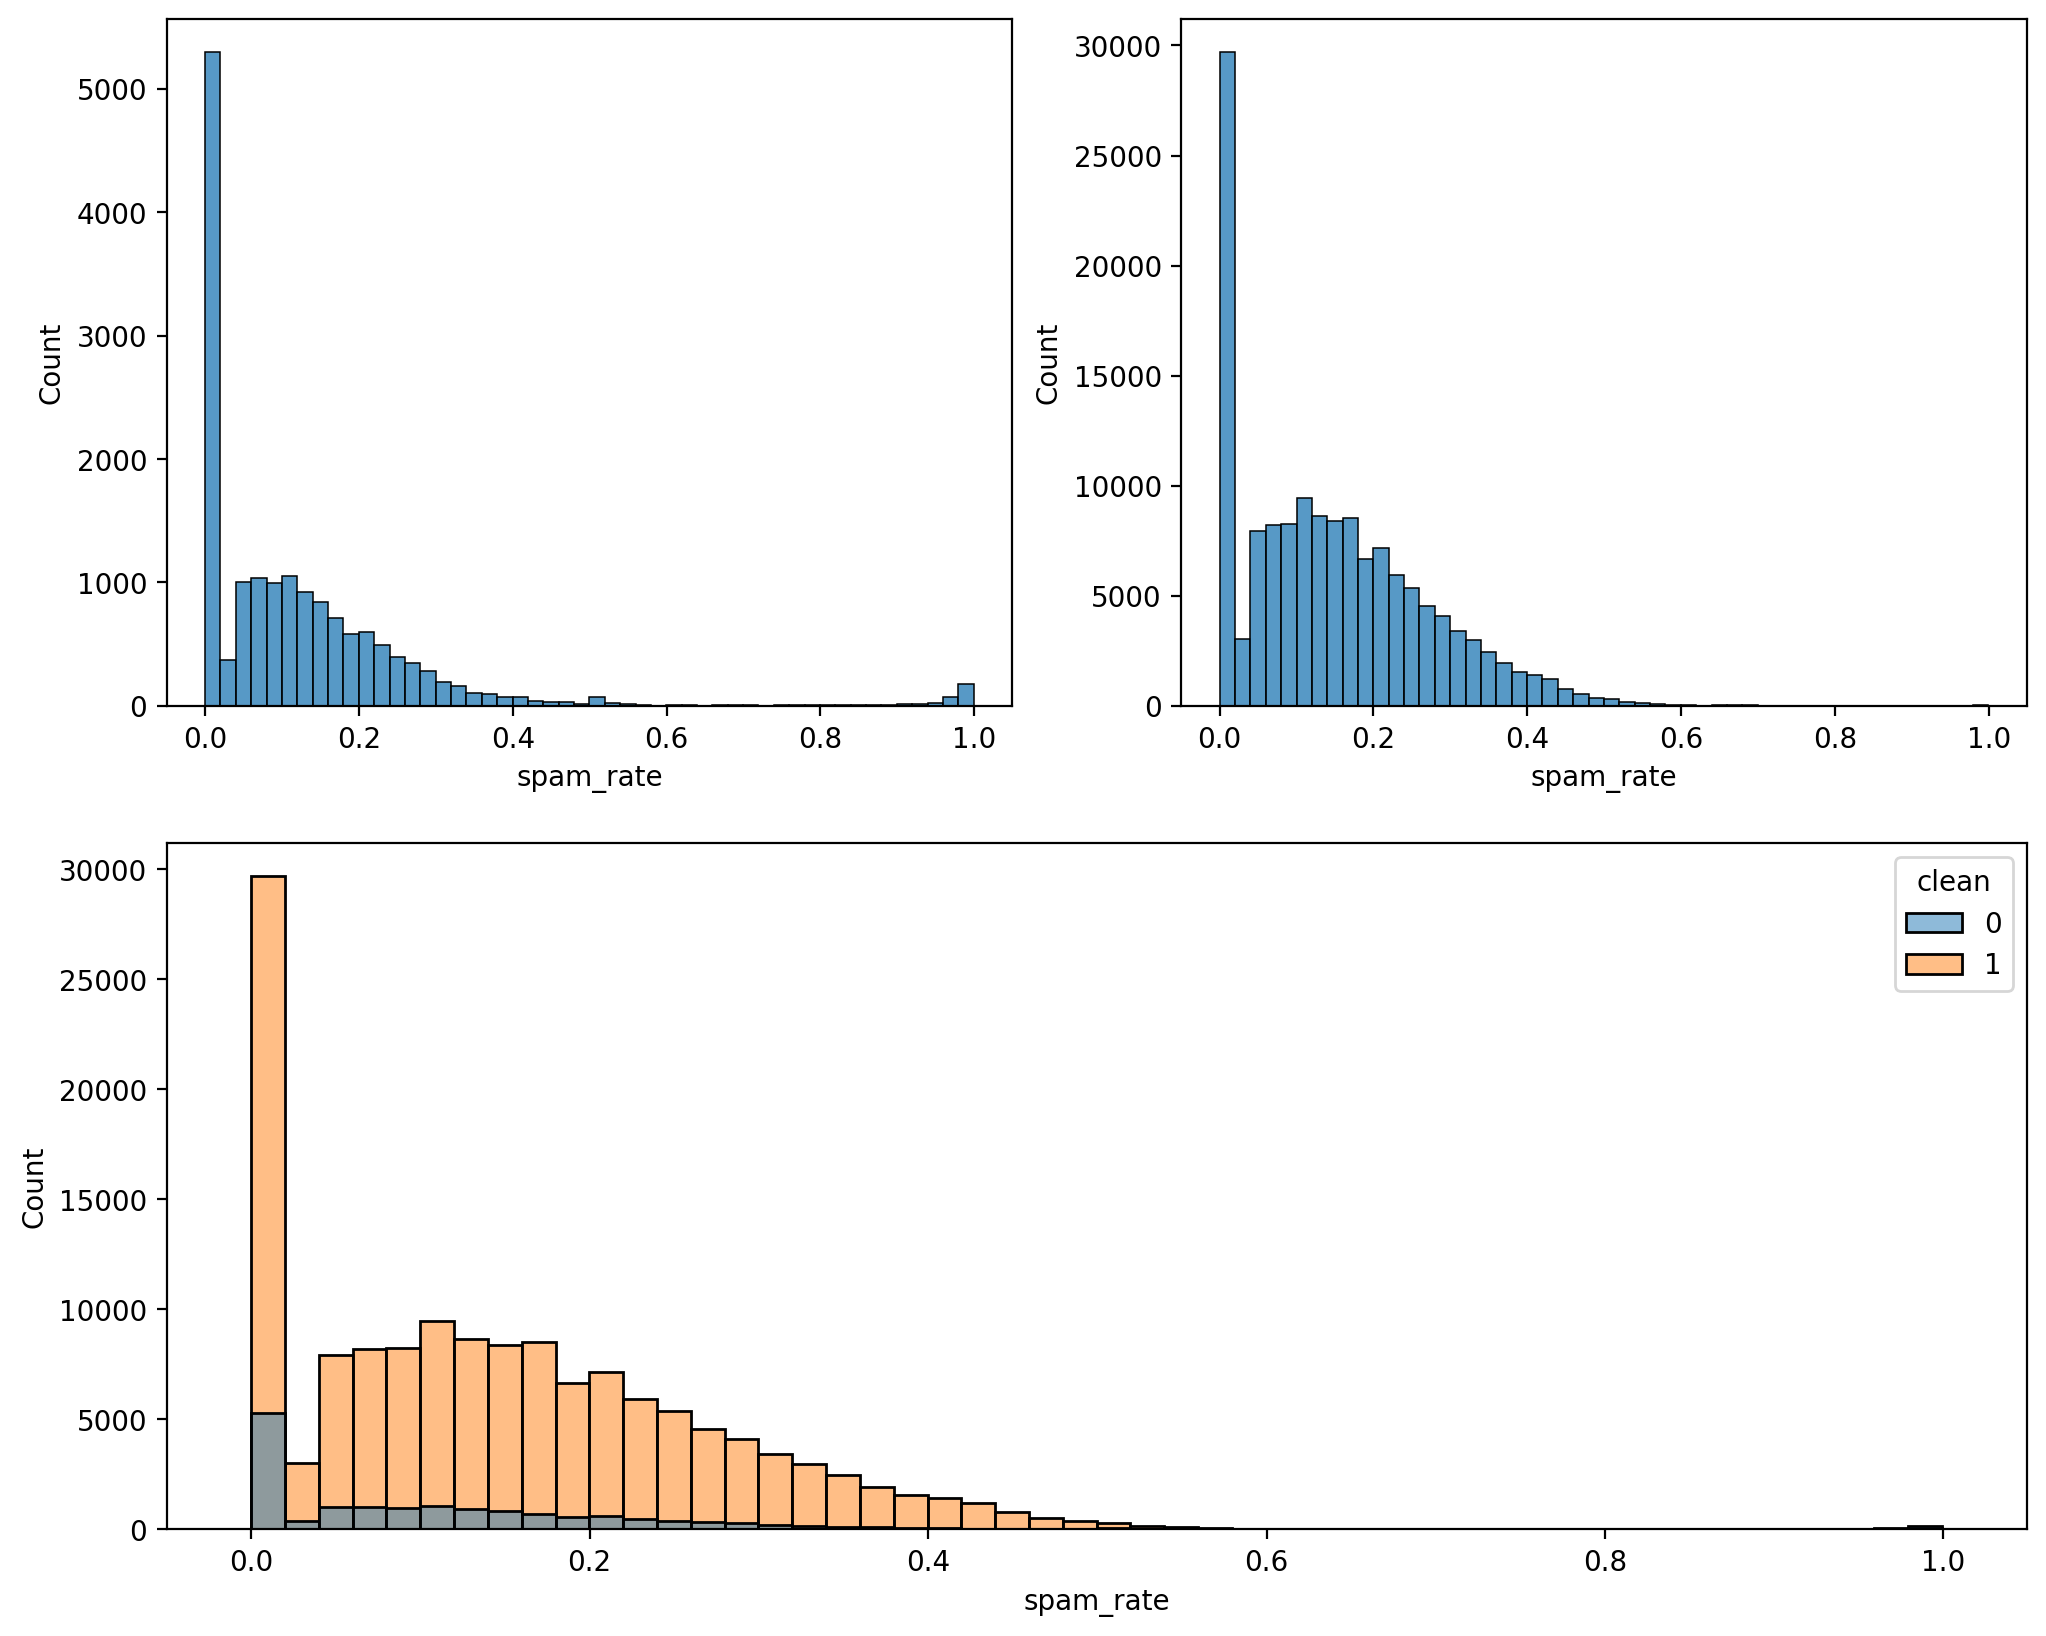

In [62]:
plot_data(f_train, 'spam_rate')

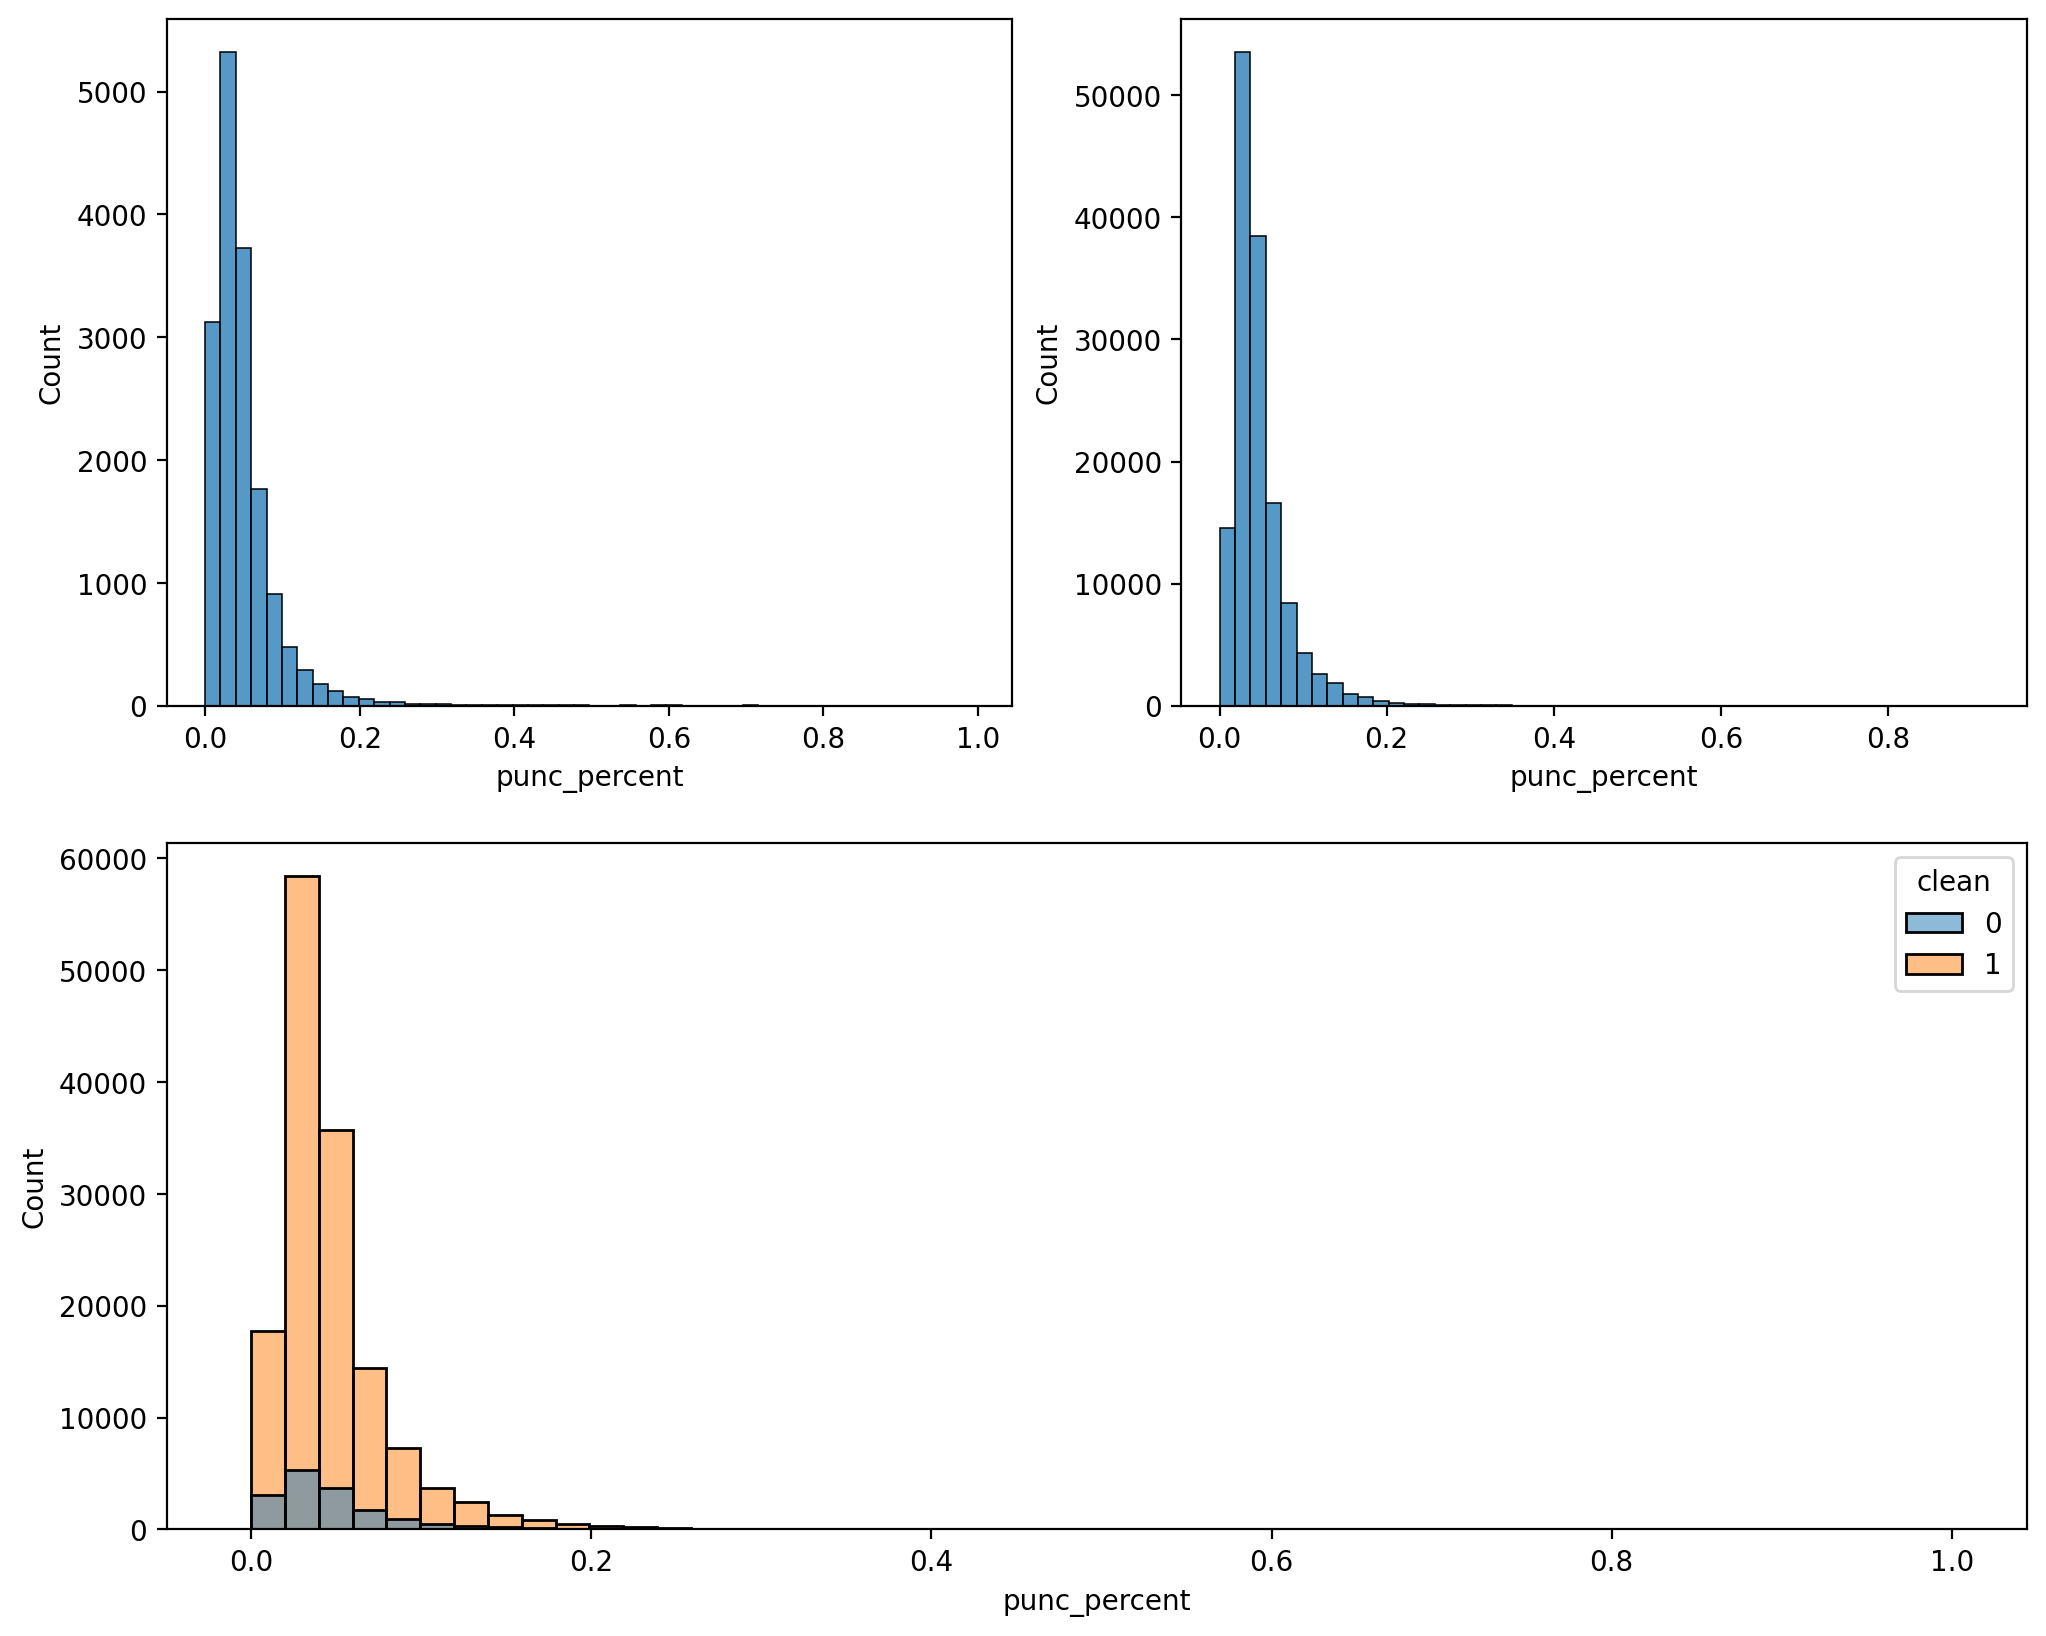

In [63]:
plot_data(f_train, 'punc_percent')

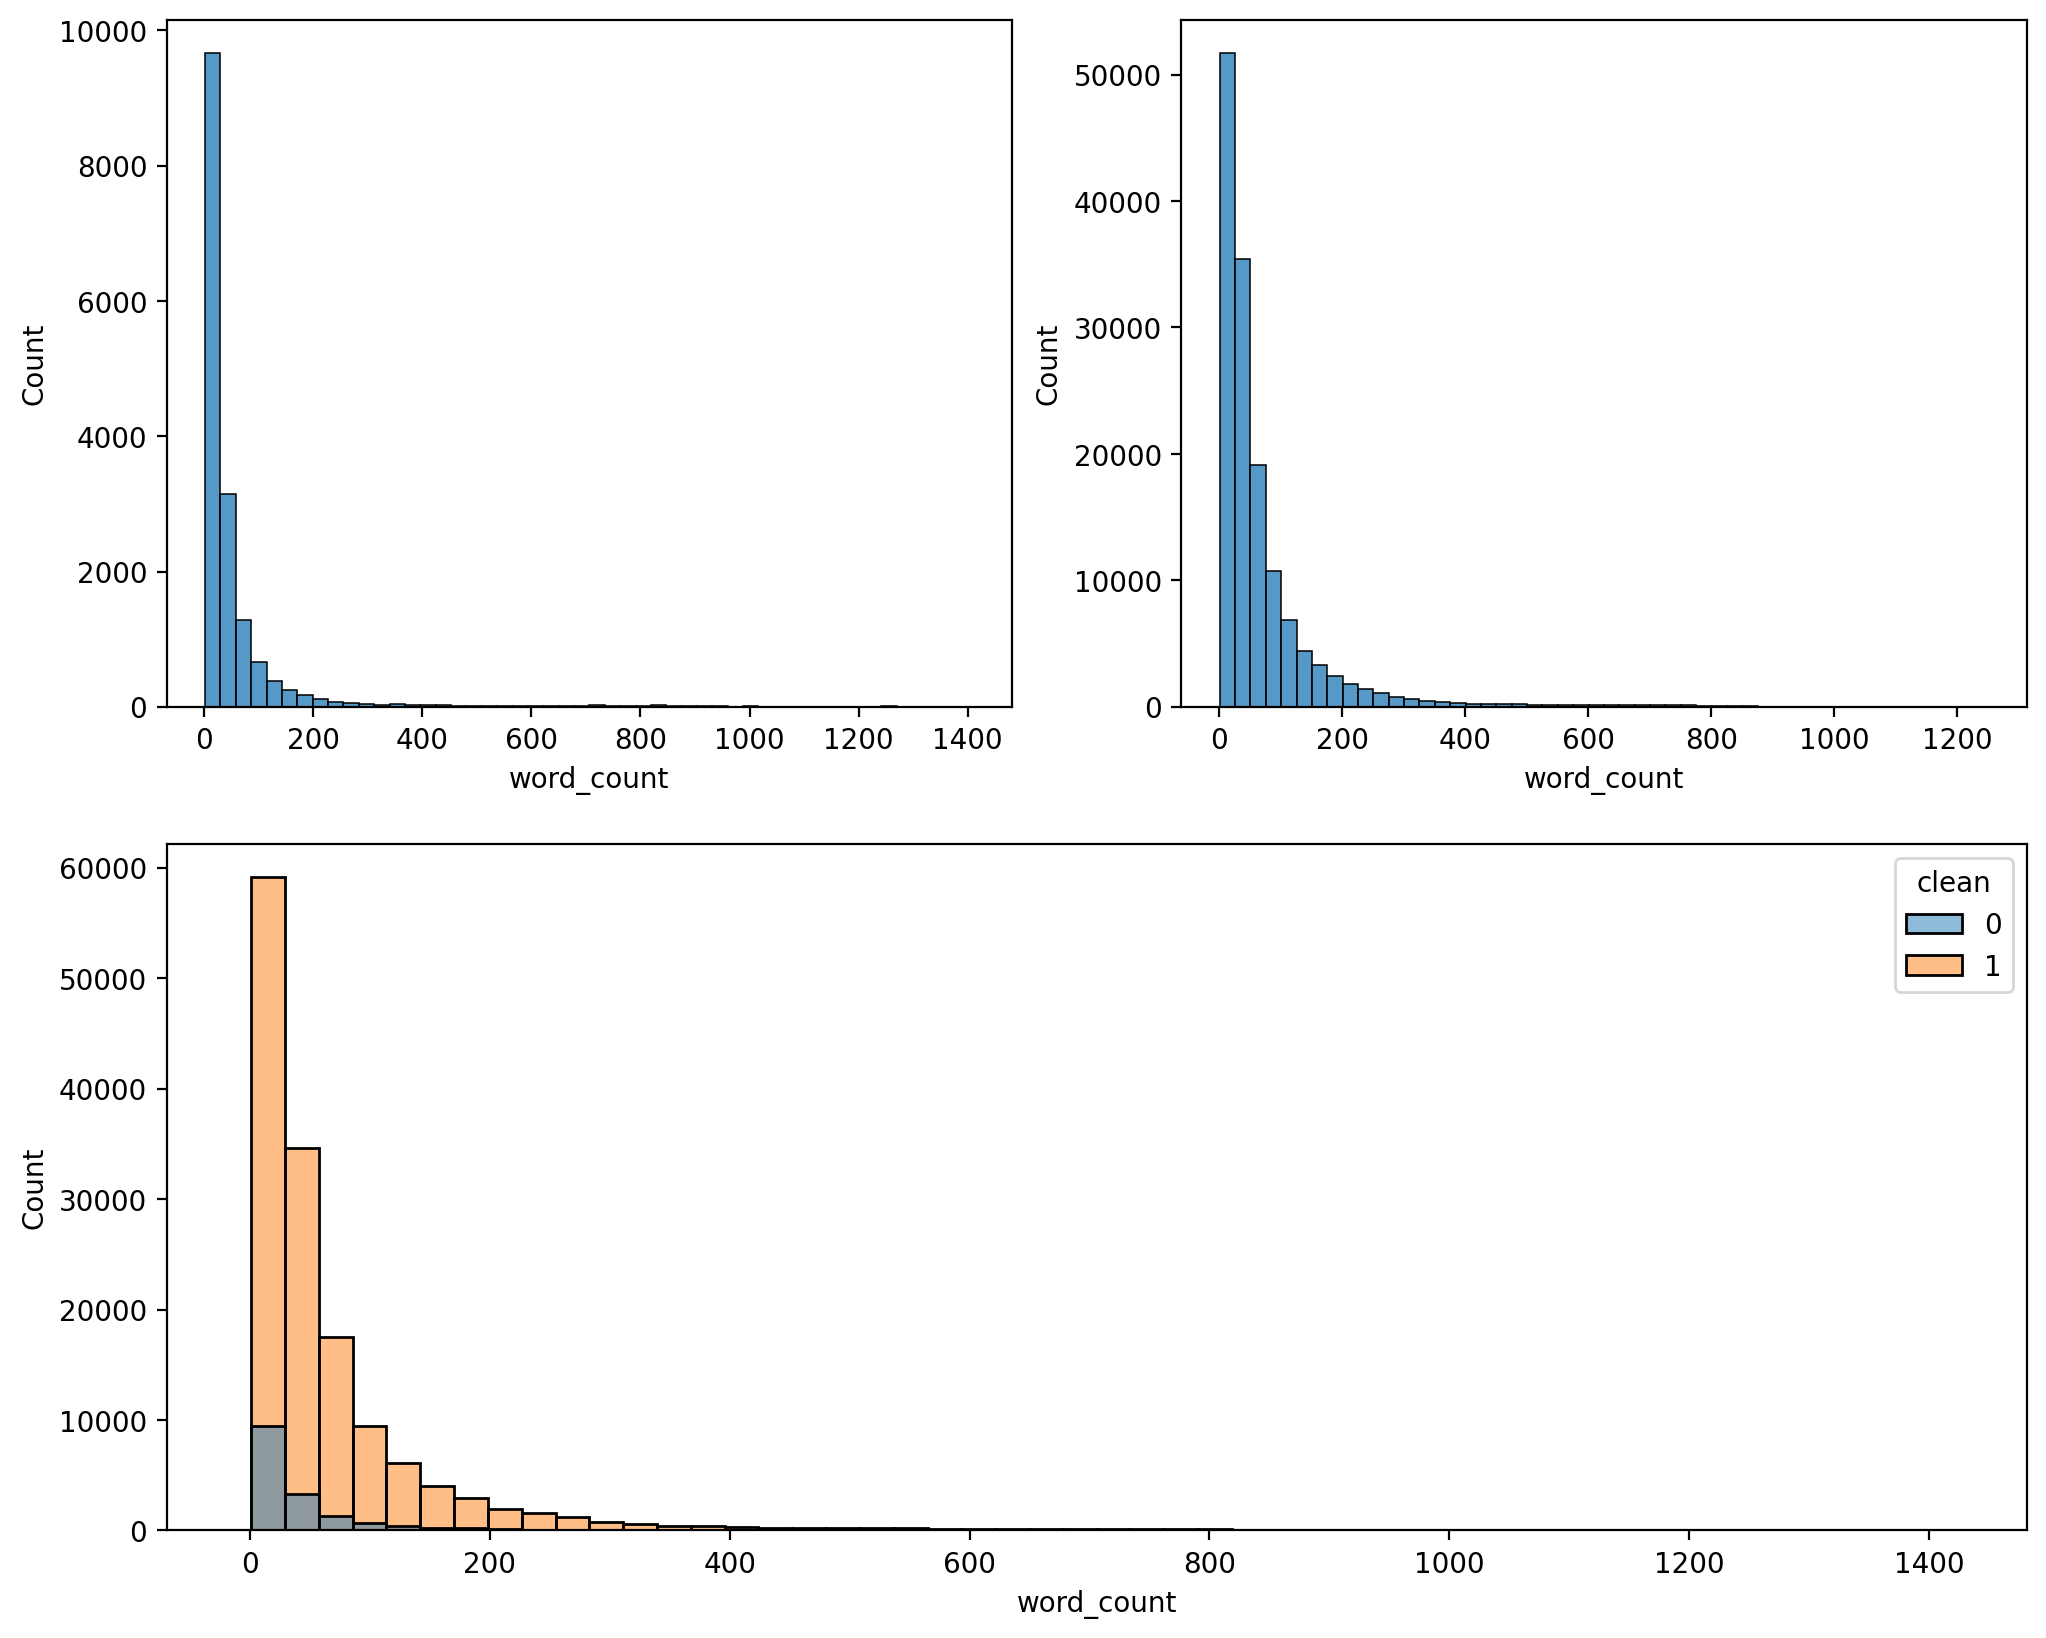

In [28]:
plot_data(f_train, 'word_count')

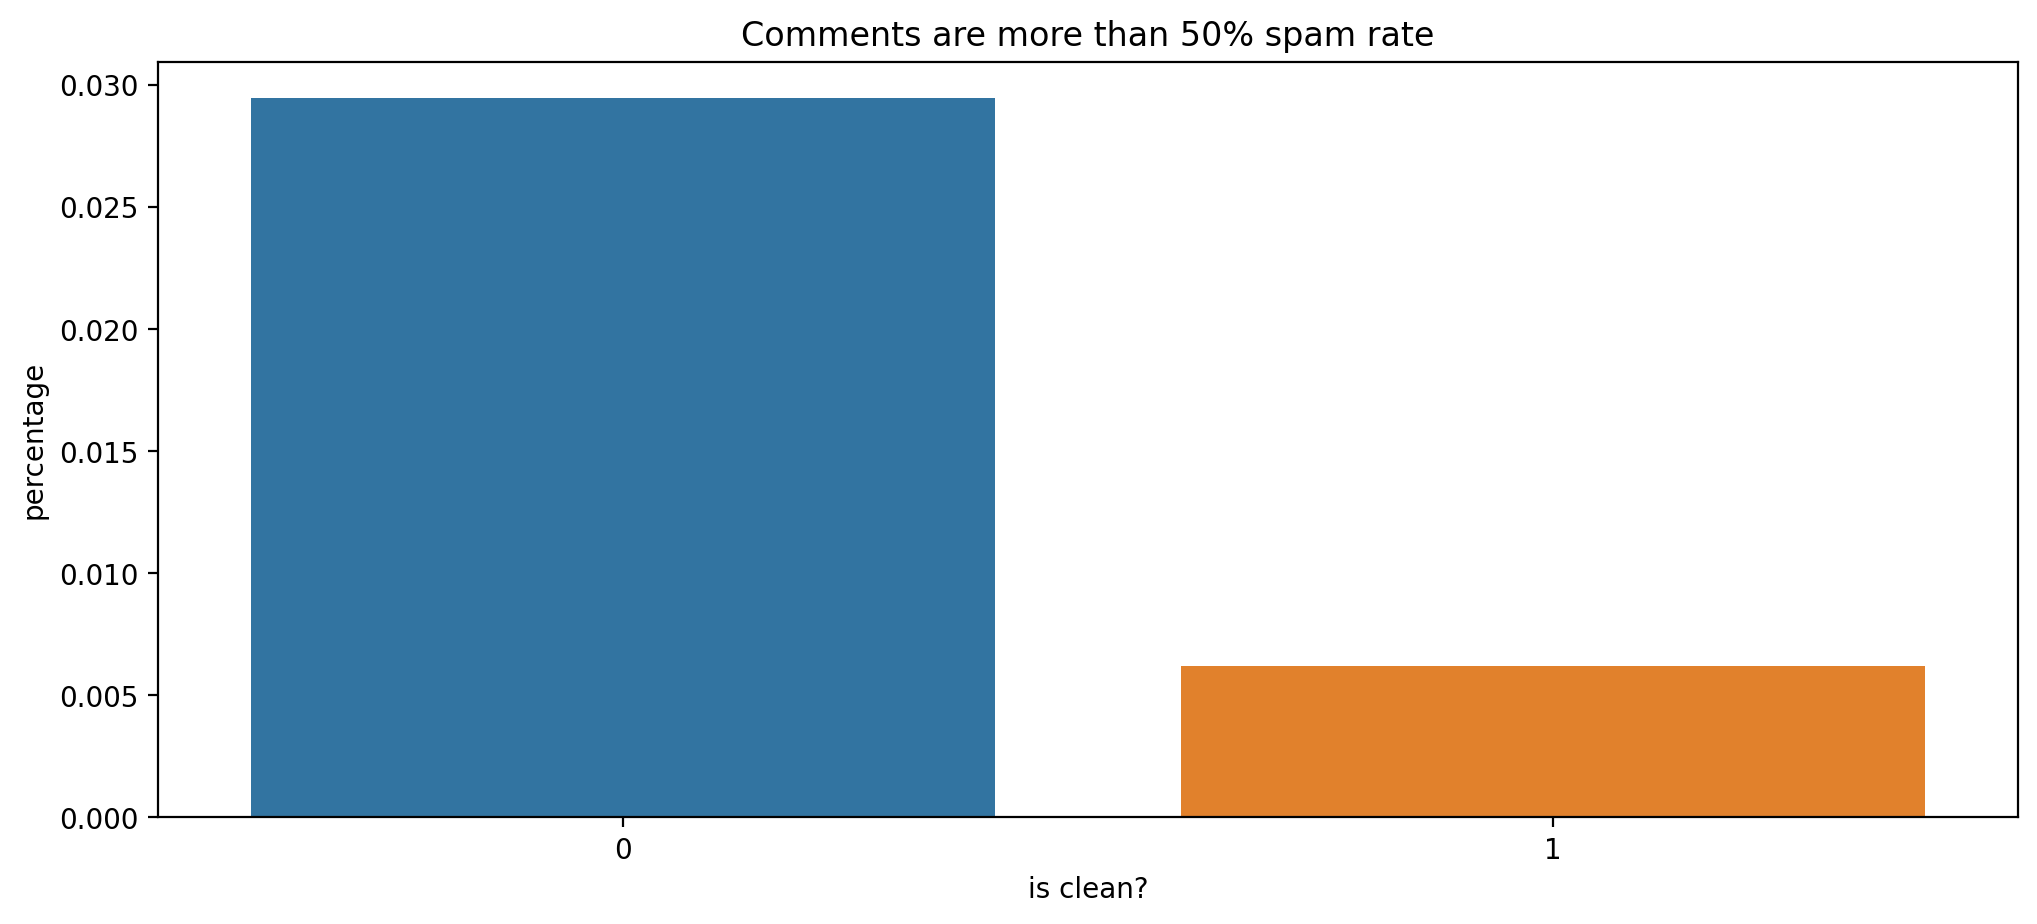

In [87]:
spam_com = f_train[f_train['spam_rate'] >= 0.5]['clean'].value_counts() / f_train['clean'].value_counts()
plt.figure(figsize=(12, 5), dpi=200)
sns.barplot(x=spam_com.index, y=spam_com.values)
plt.xlabel('is clean?')
plt.ylabel('percentage')
plt.title('Comments are more than 50% spam rate')
plt.show()

In [174]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize1(s): 
    return re_tok.sub(r' \1 ', s).split()

In [175]:
vec = TfidfVectorizer(tokenizer=tokenize1, use_idf=1, strip_accents='unicode', 
                      sublinear_tf=1, max_df=0.9, min_df=3, ngram_range=(1, 2))
trn_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [ ]:
df = pd.DataFrame(trn_term_doc[0].T.todense(), index=vec.get_feature_names_out(), columns=['tf-idf'])
df =df.sort_values('tf-idf', ascending=0)

In [ ]:
def naive_bayes(label, values):
    im_val = trn_term_doc[values == label].sum(0)
    return (im_val + 1) / ((values == label).sum() + 1)

In [ ]:
def get_model(values):
    r = np.log(naive_bayes(1, values) / naive_bayes(0, values))
    model = LogisticRegression(C=4)
    x_train = trn_term_doc.multiply(r)
    return model.fit(x_train, values), r

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 
          'threat', 'insult', 'identity_hate']
preds = np.zeros((len(test), len(labels)))
for index, label in enumerate(labels):
    print(f'fit {label}')
    model, r = get_model(train[label].values)
    preds[:, index] = model.predict_proba(test_term_doc.multiply(r))[:, 1]

In [ ]:
preds.round()

In [ ]:
sub = pd.concat([test, pd.DataFrame(preds, columns=labels)], axis=1)
sub.drop(columns='comment_text', inplace=True)

In [ ]:
sub.to_csv('sub.csv', index=False, encoding='utf-8')